### Import necessary libraries

In [13]:
import json
import os
import requests
import pandas as pd
import scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### Create csv files with below block: (No need to run if files are already created) (must have json file in same folder as jupyter script)

In [8]:
# Global Constants used throughout script
CMS_API_URL_FORMAT = "https://data.cms.gov/data-api/v1/dataset/{}/data"
CONFIG_FILE = "data_generator_config.json"
ROOT = "data"

with open(CONFIG_FILE, 'r') as file:
    config = json.load(file)

main_frames = []

for name, info in config.items():
    
    print(f"Beginning loading of {name}")
    dataframes = []

    # Each UUID represents an individual year of this dataset
    # We shall merge them all together
    for year, uuid in info['UUID'].items():
        request_url = CMS_API_URL_FORMAT.format(uuid)

        print(f"Requesting {uuid}")
        r = requests.get(request_url)
        tmp = pd.read_json(r.text)
        tmp['year'] = year
        dataframes.append(tmp)

    data = pd.concat(dataframes)
    main_frames.append(data)

    file_name = name + '.csv'
    
    print(f"Saving aggregated data of {name} into {file_name}")
    data.to_csv(file_name)

Beginning loading of Physician & Other Practitioners
Requesting 862ed658-1f38-4b2f-b02b-0b359e12c78a
Requesting 5fccd951-9538-48a7-9075-6f02b9867868
Requesting 02c0692d-e2d9-4714-80c7-a1d16d72ec66
Requesting 7ebc578d-c2c7-46fd-8cc8-1b035eba7218
Requesting 5055d307-4fb3-4474-adbb-a11f4182ee35
Requesting 0ccba18d-b821-47c6-bb55-269b78921637
Requesting e6aacd22-1b89-4914-855c-f8dacbd2ec60
Requesting ebaf67d7-1572-4419-a053-c8631cc1cc9b
Saving aggregated data of Physician & Other Practitioners into Physician & Other Practitioners.csv
Beginning loading of Prescribers Part D
Requesting 016d9d07-83eb-434d-91cb-0e7183d89492
Requesting 5a27f7a8-c7af-434f-a26c-54db03e22cd1
Requesting 4861ecfc-a656-4dcd-accb-b9c3b840dfcb
Requesting 04b93a42-c533-4e5c-8df9-a8f254886cde
Requesting 0015c60c-af38-4d06-98bd-f058c0abb778
Requesting 5da1b683-99ea-4734-8216-66ffdcd5e443
Requesting 2af61f9c-327c-4a23-8b7f-15e38b56e25a
Requesting 92d814bd-e2fb-48c2-95e7-a4b388a2c4be
Saving aggregated data of Prescribers Pa

In [2]:
physicians = pd.read_csv('Physician & Other Practitioners.csv')
prescribers = pd.read_csv('Prescribers Part D.csv')
DMEPOS = pd.read_csv('DMEPOS.csv')

In [3]:
physicians.head(10)
physicians.shape

(8000, 31)

In [4]:
prescribers.head()
prescribers.shape

(8000, 24)

In [5]:
DMEPOS.head()
DMEPOS.shape

(8000, 40)

### Physicians DB bivariant analysis

In [6]:
physicians.dtypes


Unnamed: 0                         int64
Rndrng_NPI                         int64
Rndrng_Prvdr_Last_Org_Name        object
Rndrng_Prvdr_First_Name           object
Rndrng_Prvdr_MI                   object
Rndrng_Prvdr_Crdntls              object
Rndrng_Prvdr_Gndr                 object
Rndrng_Prvdr_Ent_Cd               object
Rndrng_Prvdr_St1                  object
Rndrng_Prvdr_St2                  object
Rndrng_Prvdr_City                 object
Rndrng_Prvdr_State_Abrvtn         object
Rndrng_Prvdr_State_FIPS            int64
Rndrng_Prvdr_Zip5                  int64
Rndrng_Prvdr_RUCA                float64
Rndrng_Prvdr_RUCA_Desc            object
Rndrng_Prvdr_Cntry                object
Rndrng_Prvdr_Type                 object
Rndrng_Prvdr_Mdcr_Prtcptg_Ind     object
HCPCS_Cd                          object
HCPCS_Desc                        object
HCPCS_Drug_Ind                    object
Place_Of_Srvc                     object
Tot_Benes                          int64
Tot_Srvcs       

### Find object types that can be converted to discrete numeric

In [7]:
ph_df = physicians[["Rndrng_Prvdr_State_FIPS","Rndrng_Prvdr_Zip5","Rndrng_Prvdr_RUCA","HCPCS_Drug_Ind","Place_Of_Srvc","Tot_Benes","Tot_Srvcs","Tot_Bene_Day_Srvcs","Avg_Sbmtd_Chrg","Avg_Mdcr_Alowd_Amt","Avg_Mdcr_Pymt_Amt","Avg_Mdcr_Stdzd_Amt","year"]]


print(set(ph_df["HCPCS_Drug_Ind"]))
print(set(ph_df["Place_Of_Srvc"]))

#print(set(ph_df["HCPCS_Cd"]))
#print(set(ph_df["Rndrng_Prvdr_Mdcr_Prtcptg_Ind"]))
#print(set(ph_df["Rndrng_Prvdr_Type"]))
ph_df["HCPCS_Drug_Ind"].replace(['N', 'Y'],[0,1],inplace=True)
ph_df["Place_Of_Srvc"].replace(['O', 'F'],[0,1],inplace=True)

{'N', 'Y'}
{'O', 'F'}


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [51]:
ph_df.dtypes

Rndrng_Prvdr_State_FIPS      int64
Rndrng_Prvdr_Zip5            int64
Rndrng_Prvdr_RUCA          float64
HCPCS_Drug_Ind               int64
Place_Of_Srvc                int64
Tot_Benes                    int64
Tot_Srvcs                  float64
Tot_Bene_Day_Srvcs           int64
Avg_Sbmtd_Chrg             float64
Avg_Mdcr_Alowd_Amt         float64
Avg_Mdcr_Pymt_Amt          float64
Avg_Mdcr_Stdzd_Amt         float64
year                         int64
dtype: object

### Run analysis for all possible pairs

Analysis of Rndrng_Prvdr_State_FIPS and Rndrng_Prvdr_Zip5
Scatter plot: 


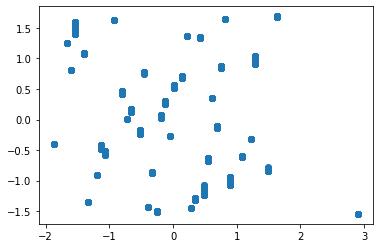

Logistic regression: 
coefficient of determination: 0.11756354334572161
slope: [[-0.3428754]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Rndrng_Prvdr_Zip5
Rndrng_Prvdr_State_FIPS                 1.000000          -0.342875
Rndrng_Prvdr_Zip5                      -0.342875           1.000000
Analysis of Rndrng_Prvdr_State_FIPS and Rndrng_Prvdr_RUCA
Scatter plot: 


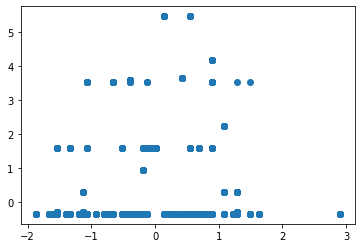

Logistic regression: 
coefficient of determination: 6.142492995253601e-05
slope: [[0.00783741]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Rndrng_Prvdr_RUCA
Rndrng_Prvdr_State_FIPS                 1.000000           0.007837
Rndrng_Prvdr_RUCA                       0.007837           1.000000
Analysis of Rndrng_Prvdr_State_FIPS and HCPCS_Drug_Ind
Scatter plot: 


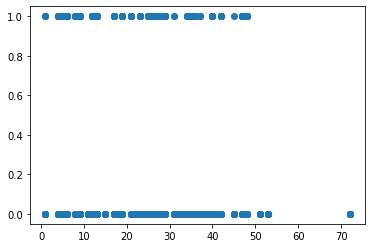

Logistic regression: 
coefficient of determination: 0.010140532498082666
slope: [[-0.00172683]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  HCPCS_Drug_Ind
Rndrng_Prvdr_State_FIPS                   1.0000         -0.1007
HCPCS_Drug_Ind                           -0.1007          1.0000
Analysis of Rndrng_Prvdr_State_FIPS and Place_Of_Srvc
Scatter plot: 


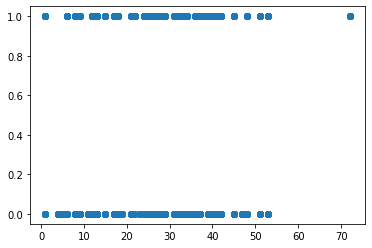

Logistic regression: 
coefficient of determination: 0.03858851129244101
slope: [[0.00644342]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Place_Of_Srvc
Rndrng_Prvdr_State_FIPS                  1.00000        0.19644
Place_Of_Srvc                            0.19644        1.00000
Analysis of Rndrng_Prvdr_State_FIPS and Tot_Benes
Scatter plot: 


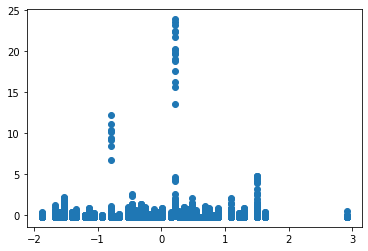

Logistic regression: 
coefficient of determination: 0.00010143553590780119
slope: [[0.01007152]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Tot_Benes
Rndrng_Prvdr_State_FIPS                 1.000000   0.010072
Tot_Benes                               0.010072   1.000000
Analysis of Rndrng_Prvdr_State_FIPS and Tot_Srvcs
Scatter plot: 


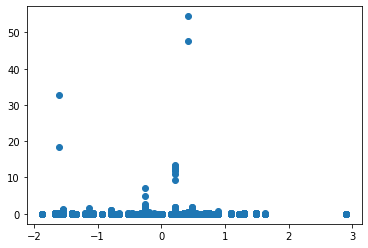

Logistic regression: 
coefficient of determination: 7.745548095960952e-05
slope: [[-0.00880088]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Tot_Srvcs
Rndrng_Prvdr_State_FIPS                 1.000000  -0.008801
Tot_Srvcs                              -0.008801   1.000000
Analysis of Rndrng_Prvdr_State_FIPS and Tot_Bene_Day_Srvcs
Scatter plot: 


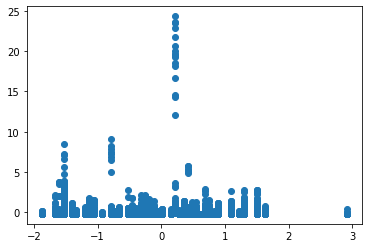

Logistic regression: 
coefficient of determination: 0.00033432533239186046
slope: [[-0.01828457]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Tot_Bene_Day_Srvcs
Rndrng_Prvdr_State_FIPS                 1.000000           -0.018285
Tot_Bene_Day_Srvcs                     -0.018285            1.000000
Analysis of Rndrng_Prvdr_State_FIPS and Avg_Sbmtd_Chrg
Scatter plot: 


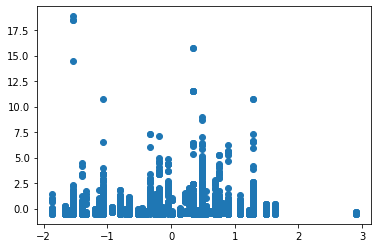

Logistic regression: 
coefficient of determination: 0.0034433725836672258
slope: [[0.05868026]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Avg_Sbmtd_Chrg
Rndrng_Prvdr_State_FIPS                  1.00000         0.05868
Avg_Sbmtd_Chrg                           0.05868         1.00000
Analysis of Rndrng_Prvdr_State_FIPS and Avg_Mdcr_Alowd_Amt
Scatter plot: 


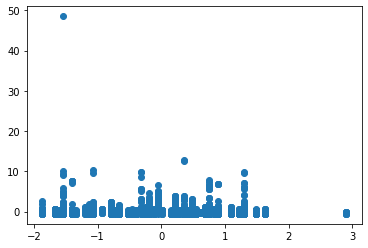

Logistic regression: 
coefficient of determination: 0.0001452607733795075
slope: [[0.01205242]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Avg_Mdcr_Alowd_Amt
Rndrng_Prvdr_State_FIPS                 1.000000            0.012052
Avg_Mdcr_Alowd_Amt                      0.012052            1.000000
Analysis of Rndrng_Prvdr_State_FIPS and Avg_Mdcr_Pymt_Amt
Scatter plot: 


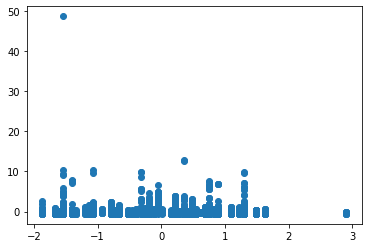

Logistic regression: 
coefficient of determination: 0.00018976658868707919
slope: [[0.01377558]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Avg_Mdcr_Pymt_Amt
Rndrng_Prvdr_State_FIPS                 1.000000           0.013776
Avg_Mdcr_Pymt_Amt                       0.013776           1.000000
Analysis of Rndrng_Prvdr_State_FIPS and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


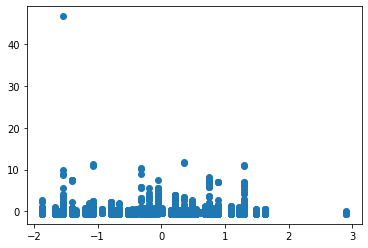

Logistic regression: 
coefficient of determination: 0.0002768881055040806
slope: [[0.01663996]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS  Avg_Mdcr_Stdzd_Amt
Rndrng_Prvdr_State_FIPS                  1.00000             0.01664
Avg_Mdcr_Stdzd_Amt                       0.01664             1.00000
Analysis of Rndrng_Prvdr_State_FIPS and year
Scatter plot: 


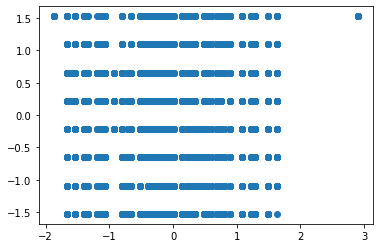

Logistic regression: 
coefficient of determination: 0.0005098268797700811
slope: [[0.02257935]]
Correlation: 
                         Rndrng_Prvdr_State_FIPS      year
Rndrng_Prvdr_State_FIPS                 1.000000  0.022579
year                                    0.022579  1.000000
Analysis of Rndrng_Prvdr_Zip5 and Rndrng_Prvdr_RUCA
Scatter plot: 


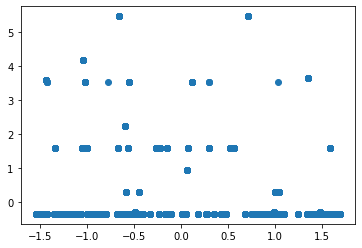

Logistic regression: 
coefficient of determination: 0.004832258935023925
slope: [[-0.06951445]]
Correlation: 
                   Rndrng_Prvdr_Zip5  Rndrng_Prvdr_RUCA
Rndrng_Prvdr_Zip5           1.000000          -0.069514
Rndrng_Prvdr_RUCA          -0.069514           1.000000
Analysis of Rndrng_Prvdr_Zip5 and HCPCS_Drug_Ind
Scatter plot: 


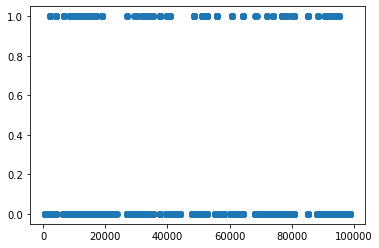

Logistic regression: 
coefficient of determination: 0.002463465918886576
slope: [[-4.17611652e-07]]
Correlation: 
                   Rndrng_Prvdr_Zip5  HCPCS_Drug_Ind
Rndrng_Prvdr_Zip5           1.000000       -0.049633
HCPCS_Drug_Ind             -0.049633        1.000000
Analysis of Rndrng_Prvdr_Zip5 and Place_Of_Srvc
Scatter plot: 


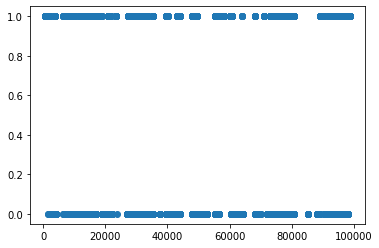

Logistic regression: 
coefficient of determination: 0.0003765852587801488
slope: [[3.12319673e-07]]
Correlation: 
                   Rndrng_Prvdr_Zip5  Place_Of_Srvc
Rndrng_Prvdr_Zip5           1.000000       0.019406
Place_Of_Srvc               0.019406       1.000000
Analysis of Rndrng_Prvdr_Zip5 and Tot_Benes
Scatter plot: 


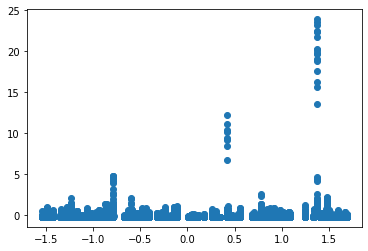

Logistic regression: 
coefficient of determination: 0.0035683695955348593
slope: [[0.05973583]]
Correlation: 
                   Rndrng_Prvdr_Zip5  Tot_Benes
Rndrng_Prvdr_Zip5           1.000000   0.059736
Tot_Benes                   0.059736   1.000000
Analysis of Rndrng_Prvdr_Zip5 and Tot_Srvcs
Scatter plot: 


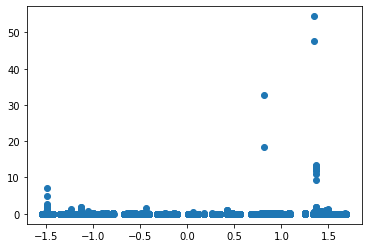

Logistic regression: 
coefficient of determination: 0.00148636419981929
slope: [[0.03855339]]
Correlation: 
                   Rndrng_Prvdr_Zip5  Tot_Srvcs
Rndrng_Prvdr_Zip5           1.000000   0.038553
Tot_Srvcs                   0.038553   1.000000
Analysis of Rndrng_Prvdr_Zip5 and Tot_Bene_Day_Srvcs
Scatter plot: 


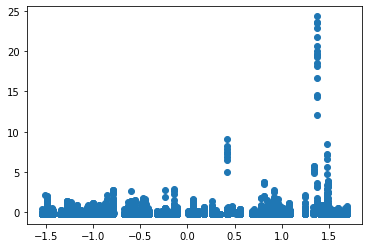

Logistic regression: 
coefficient of determination: 0.006219413187972256
slope: [[0.07886326]]
Correlation: 
                    Rndrng_Prvdr_Zip5  Tot_Bene_Day_Srvcs
Rndrng_Prvdr_Zip5            1.000000            0.078863
Tot_Bene_Day_Srvcs           0.078863            1.000000
Analysis of Rndrng_Prvdr_Zip5 and Avg_Sbmtd_Chrg
Scatter plot: 


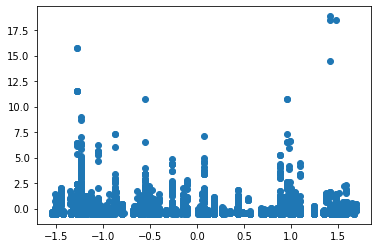

Logistic regression: 
coefficient of determination: 0.009329248172001092
slope: [[-0.09658803]]
Correlation: 
                   Rndrng_Prvdr_Zip5  Avg_Sbmtd_Chrg
Rndrng_Prvdr_Zip5           1.000000       -0.096588
Avg_Sbmtd_Chrg             -0.096588        1.000000
Analysis of Rndrng_Prvdr_Zip5 and Avg_Mdcr_Alowd_Amt
Scatter plot: 


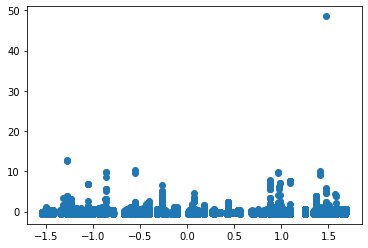

Logistic regression: 
coefficient of determination: 6.385332390723697e-05
slope: [[0.00799083]]
Correlation: 
                    Rndrng_Prvdr_Zip5  Avg_Mdcr_Alowd_Amt
Rndrng_Prvdr_Zip5            1.000000            0.007991
Avg_Mdcr_Alowd_Amt           0.007991            1.000000
Analysis of Rndrng_Prvdr_Zip5 and Avg_Mdcr_Pymt_Amt
Scatter plot: 


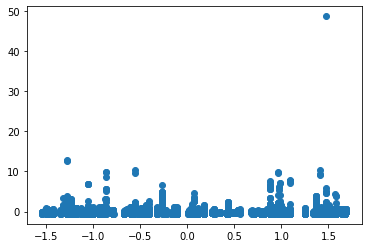

Logistic regression: 
coefficient of determination: 2.434383671678919e-05
slope: [[0.00493395]]
Correlation: 
                   Rndrng_Prvdr_Zip5  Avg_Mdcr_Pymt_Amt
Rndrng_Prvdr_Zip5           1.000000           0.004934
Avg_Mdcr_Pymt_Amt           0.004934           1.000000
Analysis of Rndrng_Prvdr_Zip5 and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


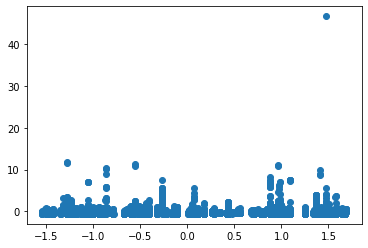

Logistic regression: 
coefficient of determination: 0.00022336628212282772
slope: [[0.01494544]]
Correlation: 
                    Rndrng_Prvdr_Zip5  Avg_Mdcr_Stdzd_Amt
Rndrng_Prvdr_Zip5            1.000000            0.014945
Avg_Mdcr_Stdzd_Amt           0.014945            1.000000
Analysis of Rndrng_Prvdr_Zip5 and year
Scatter plot: 


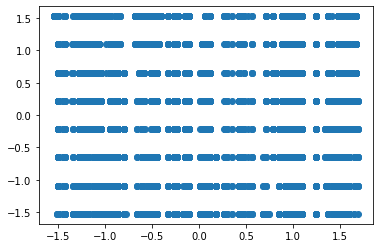

Logistic regression: 
coefficient of determination: 0.0008308803687333555
slope: [[0.028825]]
Correlation: 
                   Rndrng_Prvdr_Zip5      year
Rndrng_Prvdr_Zip5           1.000000  0.028825
year                        0.028825  1.000000
Analysis of Rndrng_Prvdr_RUCA and HCPCS_Drug_Ind
Scatter plot: 


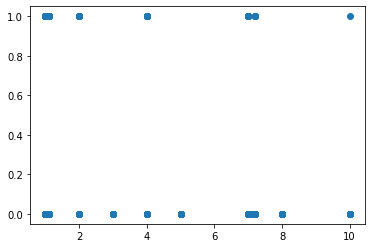

Logistic regression: 
coefficient of determination: 0.00014499016301383616
slope: [[0.00198499]]
Correlation: 
                   Rndrng_Prvdr_RUCA  HCPCS_Drug_Ind
Rndrng_Prvdr_RUCA           1.000000        0.012041
HCPCS_Drug_Ind              0.012041        1.000000
Analysis of Rndrng_Prvdr_RUCA and Place_Of_Srvc
Scatter plot: 


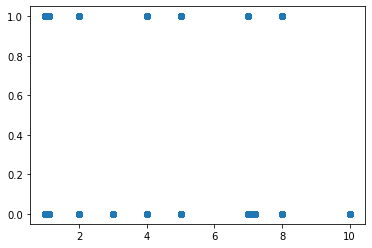

Logistic regression: 
coefficient of determination: 0.001328012112983612
slope: [[-0.011491]]
Correlation: 
                   Rndrng_Prvdr_RUCA  Place_Of_Srvc
Rndrng_Prvdr_RUCA           1.000000      -0.036442
Place_Of_Srvc              -0.036442       1.000000
Analysis of Rndrng_Prvdr_RUCA and Tot_Benes
Scatter plot: 


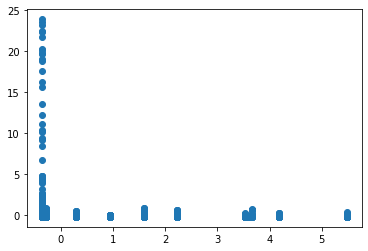

Logistic regression: 
coefficient of determination: 0.0011854416966392556
slope: [[-0.03443024]]
Correlation: 
                   Rndrng_Prvdr_RUCA  Tot_Benes
Rndrng_Prvdr_RUCA            1.00000   -0.03443
Tot_Benes                   -0.03443    1.00000
Analysis of Rndrng_Prvdr_RUCA and Tot_Srvcs
Scatter plot: 


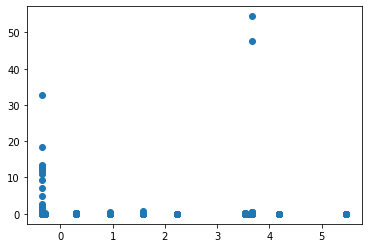

Logistic regression: 
coefficient of determination: 0.001348402971344309
slope: [[0.03672061]]
Correlation: 
                   Rndrng_Prvdr_RUCA  Tot_Srvcs
Rndrng_Prvdr_RUCA           1.000000   0.036721
Tot_Srvcs                   0.036721   1.000000
Analysis of Rndrng_Prvdr_RUCA and Tot_Bene_Day_Srvcs
Scatter plot: 


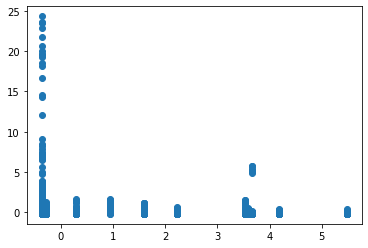

Logistic regression: 
coefficient of determination: 0.00016959110053182958
slope: [[-0.01302271]]
Correlation: 
                    Rndrng_Prvdr_RUCA  Tot_Bene_Day_Srvcs
Rndrng_Prvdr_RUCA            1.000000           -0.013023
Tot_Bene_Day_Srvcs          -0.013023            1.000000
Analysis of Rndrng_Prvdr_RUCA and Avg_Sbmtd_Chrg
Scatter plot: 


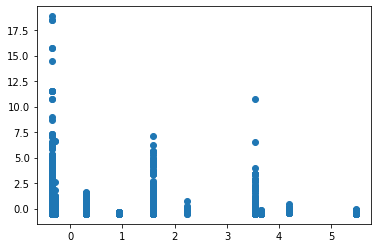

Logistic regression: 
coefficient of determination: 0.0005979604988269882
slope: [[0.02445323]]
Correlation: 
                   Rndrng_Prvdr_RUCA  Avg_Sbmtd_Chrg
Rndrng_Prvdr_RUCA           1.000000        0.024453
Avg_Sbmtd_Chrg              0.024453        1.000000
Analysis of Rndrng_Prvdr_RUCA and Avg_Mdcr_Alowd_Amt
Scatter plot: 


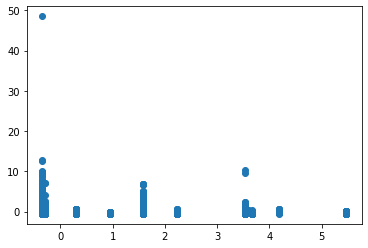

Logistic regression: 
coefficient of determination: 0.0006546527015607317
slope: [[0.02558618]]
Correlation: 
                    Rndrng_Prvdr_RUCA  Avg_Mdcr_Alowd_Amt
Rndrng_Prvdr_RUCA            1.000000            0.025586
Avg_Mdcr_Alowd_Amt           0.025586            1.000000
Analysis of Rndrng_Prvdr_RUCA and Avg_Mdcr_Pymt_Amt
Scatter plot: 


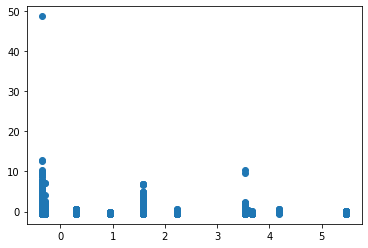

Logistic regression: 
coefficient of determination: 0.000641320906442866
slope: [[0.02532431]]
Correlation: 
                   Rndrng_Prvdr_RUCA  Avg_Mdcr_Pymt_Amt
Rndrng_Prvdr_RUCA           1.000000           0.025324
Avg_Mdcr_Pymt_Amt           0.025324           1.000000
Analysis of Rndrng_Prvdr_RUCA and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


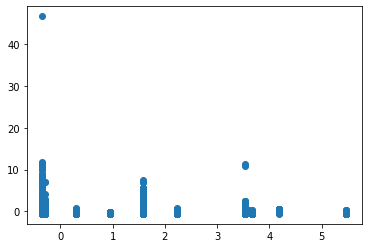

Logistic regression: 
coefficient of determination: 0.0017521666809288128
slope: [[0.04185889]]
Correlation: 
                    Rndrng_Prvdr_RUCA  Avg_Mdcr_Stdzd_Amt
Rndrng_Prvdr_RUCA            1.000000            0.041859
Avg_Mdcr_Stdzd_Amt           0.041859            1.000000
Analysis of Rndrng_Prvdr_RUCA and year
Scatter plot: 


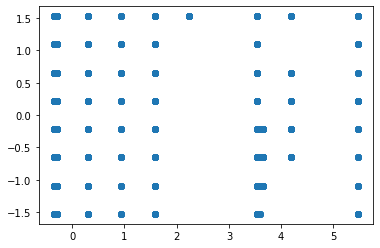

Logistic regression: 
coefficient of determination: 0.003246935875900303
slope: [[-0.05698189]]
Correlation: 
                   Rndrng_Prvdr_RUCA      year
Rndrng_Prvdr_RUCA           1.000000 -0.056982
year                       -0.056982  1.000000
Analysis of HCPCS_Drug_Ind and Place_Of_Srvc
Scatter plot: 


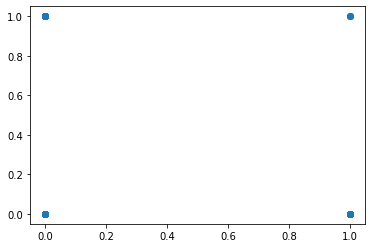

Logistic regression: 
coefficient of determination: 0.0461785040403635
slope: [[-0.41104397]]
Correlation: 
                HCPCS_Drug_Ind  Place_Of_Srvc
HCPCS_Drug_Ind        1.000000      -0.214892
Place_Of_Srvc        -0.214892       1.000000
Analysis of HCPCS_Drug_Ind and Tot_Benes
Scatter plot: 


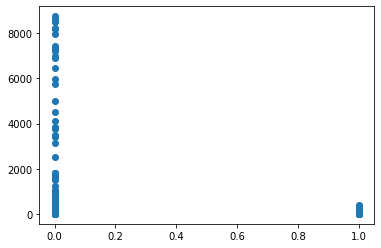

Logistic regression: 
coefficient of determination: 0.0006657676968029325
slope: [[-36.65235479]]
Correlation: 
                HCPCS_Drug_Ind  Tot_Benes
HCPCS_Drug_Ind        1.000000  -0.025802
Tot_Benes            -0.025802   1.000000
Analysis of HCPCS_Drug_Ind and Tot_Srvcs
Scatter plot: 


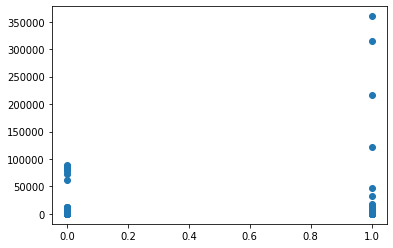

Logistic regression: 
coefficient of determination: 0.008854506738337098
slope: [[2439.2011936]]
Correlation: 
                HCPCS_Drug_Ind  Tot_Srvcs
HCPCS_Drug_Ind        1.000000   0.094098
Tot_Srvcs             0.094098   1.000000
Analysis of HCPCS_Drug_Ind and Tot_Bene_Day_Srvcs
Scatter plot: 


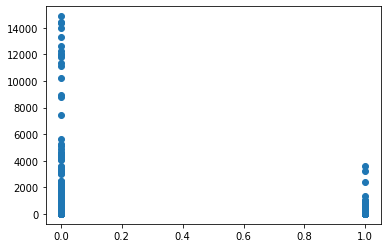

Logistic regression: 
coefficient of determination: 0.00027637701341154397
slope: [[-39.46760467]]
Correlation: 
                    HCPCS_Drug_Ind  Tot_Bene_Day_Srvcs
HCPCS_Drug_Ind            1.000000           -0.016625
Tot_Bene_Day_Srvcs       -0.016625            1.000000
Analysis of HCPCS_Drug_Ind and Avg_Sbmtd_Chrg
Scatter plot: 


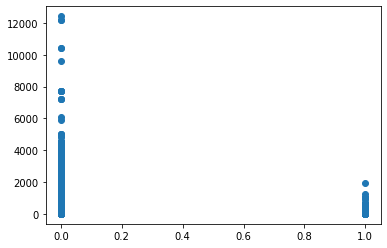

Logistic regression: 
coefficient of determination: 0.01187046728992025
slope: [[-274.13529238]]
Correlation: 
                HCPCS_Drug_Ind  Avg_Sbmtd_Chrg
HCPCS_Drug_Ind        1.000000       -0.108952
Avg_Sbmtd_Chrg       -0.108952        1.000000
Analysis of HCPCS_Drug_Ind and Avg_Mdcr_Alowd_Amt
Scatter plot: 


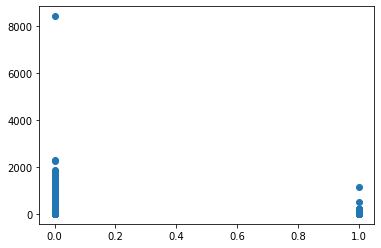

Logistic regression: 
coefficient of determination: 0.009898207463630238
slope: [[-66.82441952]]
Correlation: 
                    HCPCS_Drug_Ind  Avg_Mdcr_Alowd_Amt
HCPCS_Drug_Ind             1.00000            -0.09949
Avg_Mdcr_Alowd_Amt        -0.09949             1.00000
Analysis of HCPCS_Drug_Ind and Avg_Mdcr_Pymt_Amt
Scatter plot: 


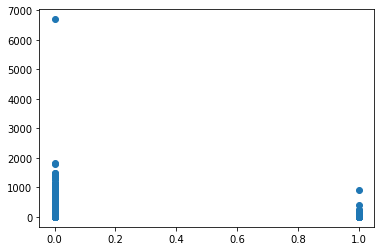

Logistic regression: 
coefficient of determination: 0.007224119607446622
slope: [[-45.37526419]]
Correlation: 
                   HCPCS_Drug_Ind  Avg_Mdcr_Pymt_Amt
HCPCS_Drug_Ind           1.000000          -0.084995
Avg_Mdcr_Pymt_Amt       -0.084995           1.000000
Analysis of HCPCS_Drug_Ind and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


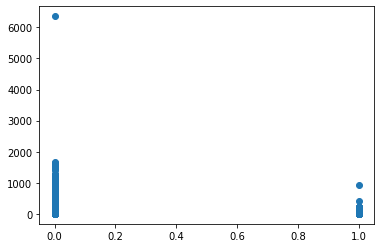

Logistic regression: 
coefficient of determination: 0.0072832939337289515
slope: [[-45.11525143]]
Correlation: 
                    HCPCS_Drug_Ind  Avg_Mdcr_Stdzd_Amt
HCPCS_Drug_Ind            1.000000           -0.085342
Avg_Mdcr_Stdzd_Amt       -0.085342            1.000000
Analysis of HCPCS_Drug_Ind and year
Scatter plot: 


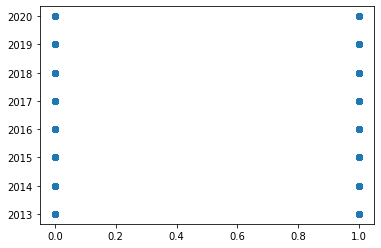

Logistic regression: 
coefficient of determination: 0.0004052962068066268
slope: [[0.18108979]]
Correlation: 
                HCPCS_Drug_Ind      year
HCPCS_Drug_Ind        1.000000  0.020132
year                  0.020132  1.000000
Analysis of Place_Of_Srvc and Tot_Benes
Scatter plot: 


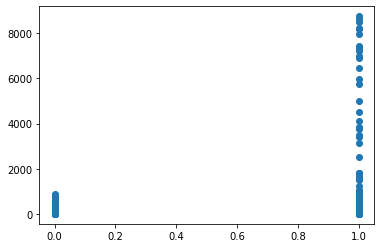

Logistic regression: 
coefficient of determination: 0.0059620594116028824
slope: [[57.34166737]]
Correlation: 
               Place_Of_Srvc  Tot_Benes
Place_Of_Srvc       1.000000   0.077214
Tot_Benes           0.077214   1.000000
Analysis of Place_Of_Srvc and Tot_Srvcs
Scatter plot: 


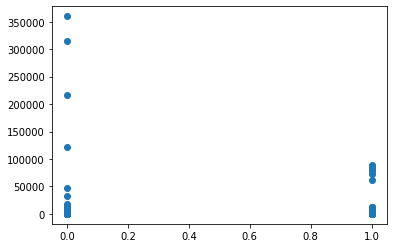

Logistic regression: 
coefficient of determination: 3.734181524295277e-05
slope: [[-82.81229024]]
Correlation: 
               Place_Of_Srvc  Tot_Srvcs
Place_Of_Srvc       1.000000  -0.006111
Tot_Srvcs          -0.006111   1.000000
Analysis of Place_Of_Srvc and Tot_Bene_Day_Srvcs
Scatter plot: 


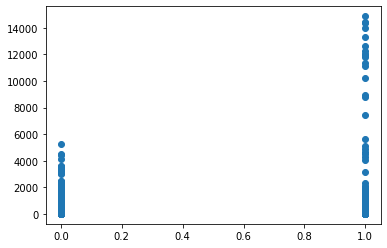

Logistic regression: 
coefficient of determination: 0.0014306751300234843
slope: [[46.94528379]]
Correlation: 
                    Place_Of_Srvc  Tot_Bene_Day_Srvcs
Place_Of_Srvc            1.000000            0.037824
Tot_Bene_Day_Srvcs       0.037824            1.000000
Analysis of Place_Of_Srvc and Avg_Sbmtd_Chrg
Scatter plot: 


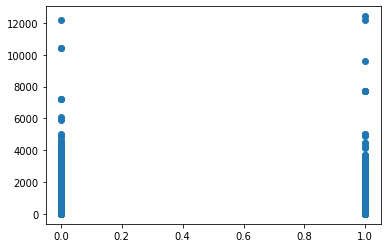

Logistic regression: 
coefficient of determination: 0.002323910903051507
slope: [[63.41214217]]
Correlation: 
                Place_Of_Srvc  Avg_Sbmtd_Chrg
Place_Of_Srvc        1.000000        0.048207
Avg_Sbmtd_Chrg       0.048207        1.000000
Analysis of Place_Of_Srvc and Avg_Mdcr_Alowd_Amt
Scatter plot: 


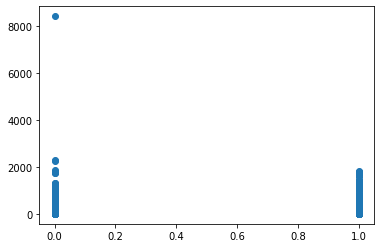

Logistic regression: 
coefficient of determination: 0.0005881125234391549
slope: [[8.51566911]]
Correlation: 
                    Place_Of_Srvc  Avg_Mdcr_Alowd_Amt
Place_Of_Srvc            1.000000            0.024251
Avg_Mdcr_Alowd_Amt       0.024251            1.000000
Analysis of Place_Of_Srvc and Avg_Mdcr_Pymt_Amt
Scatter plot: 


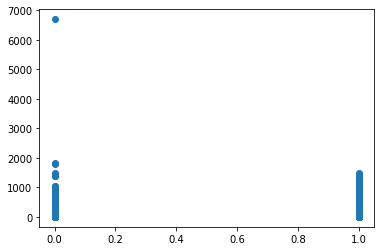

Logistic regression: 
coefficient of determination: 0.0006546109696022873
slope: [[7.14085126]]
Correlation: 
                   Place_Of_Srvc  Avg_Mdcr_Pymt_Amt
Place_Of_Srvc           1.000000           0.025585
Avg_Mdcr_Pymt_Amt       0.025585           1.000000
Analysis of Place_Of_Srvc and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


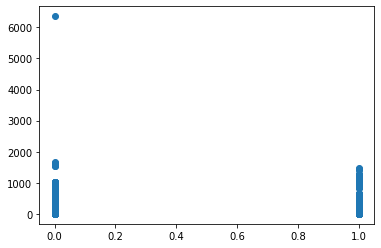

Logistic regression: 
coefficient of determination: 0.0011199633978989931
slope: [[9.2489626]]
Correlation: 
                    Place_Of_Srvc  Avg_Mdcr_Stdzd_Amt
Place_Of_Srvc            1.000000            0.033466
Avg_Mdcr_Stdzd_Amt       0.033466            1.000000
Analysis of Place_Of_Srvc and year
Scatter plot: 


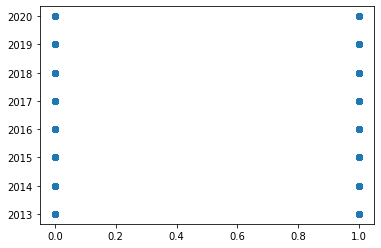

Logistic regression: 
coefficient of determination: 0.0008280305666122922
slope: [[-0.13532017]]
Correlation: 
               Place_Of_Srvc      year
Place_Of_Srvc       1.000000 -0.028776
year               -0.028776  1.000000
Analysis of Tot_Benes and Tot_Srvcs
Scatter plot: 


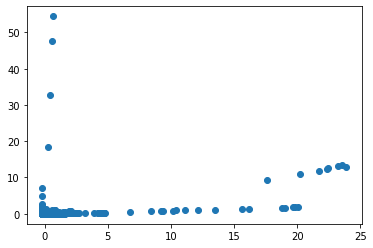

Logistic regression: 
coefficient of determination: 0.10341617562311167
slope: [[0.32158385]]
Correlation: 
           Tot_Benes  Tot_Srvcs
Tot_Benes   1.000000   0.321584
Tot_Srvcs   0.321584   1.000000
Analysis of Tot_Benes and Tot_Bene_Day_Srvcs
Scatter plot: 


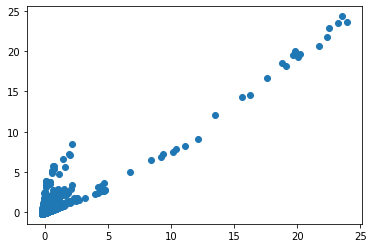

Logistic regression: 
coefficient of determination: 0.9063765945045102
slope: [[0.95203813]]
Correlation: 
                    Tot_Benes  Tot_Bene_Day_Srvcs
Tot_Benes            1.000000            0.952038
Tot_Bene_Day_Srvcs   0.952038            1.000000
Analysis of Tot_Benes and Avg_Sbmtd_Chrg
Scatter plot: 


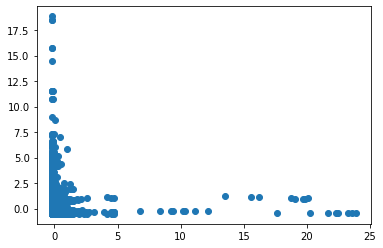

Logistic regression: 
coefficient of determination: 2.8208005915519863e-06
slope: [[-0.00167952]]
Correlation: 
                Tot_Benes  Avg_Sbmtd_Chrg
Tot_Benes         1.00000        -0.00168
Avg_Sbmtd_Chrg   -0.00168         1.00000
Analysis of Tot_Benes and Avg_Mdcr_Alowd_Amt
Scatter plot: 


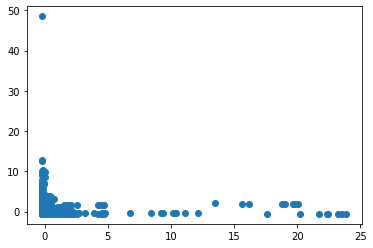

Logistic regression: 
coefficient of determination: 0.00015878809645120118
slope: [[0.01260111]]
Correlation: 
                    Tot_Benes  Avg_Mdcr_Alowd_Amt
Tot_Benes            1.000000            0.012601
Avg_Mdcr_Alowd_Amt   0.012601            1.000000
Analysis of Tot_Benes and Avg_Mdcr_Pymt_Amt
Scatter plot: 


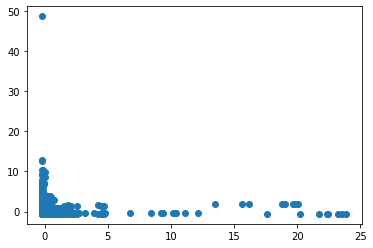

Logistic regression: 
coefficient of determination: 0.00012151232276680357
slope: [[0.01102326]]
Correlation: 
                   Tot_Benes  Avg_Mdcr_Pymt_Amt
Tot_Benes           1.000000           0.011023
Avg_Mdcr_Pymt_Amt   0.011023           1.000000
Analysis of Tot_Benes and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


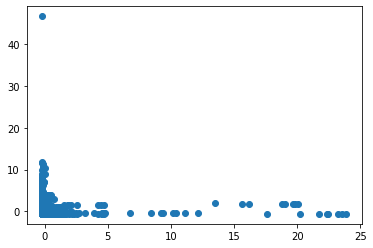

Logistic regression: 
coefficient of determination: 9.744863416638605e-05
slope: [[0.00987161]]
Correlation: 
                    Tot_Benes  Avg_Mdcr_Stdzd_Amt
Tot_Benes            1.000000            0.009872
Avg_Mdcr_Stdzd_Amt   0.009872            1.000000
Analysis of Tot_Benes and year
Scatter plot: 


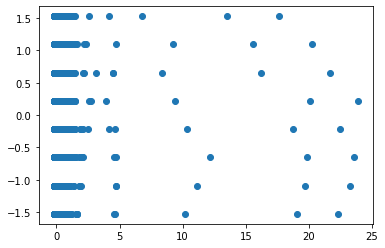

Logistic regression: 
coefficient of determination: 0.0001367802428227094
slope: [[-0.01169531]]
Correlation: 
           Tot_Benes      year
Tot_Benes   1.000000 -0.011695
year       -0.011695  1.000000
Analysis of Tot_Srvcs and Tot_Bene_Day_Srvcs
Scatter plot: 


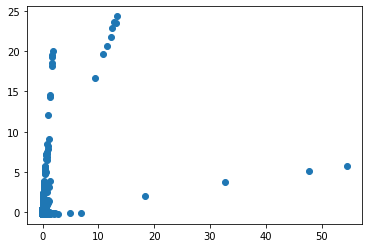

Logistic regression: 
coefficient of determination: 0.16407503336503515
slope: [[0.40506176]]
Correlation: 
                    Tot_Srvcs  Tot_Bene_Day_Srvcs
Tot_Srvcs            1.000000            0.405062
Tot_Bene_Day_Srvcs   0.405062            1.000000
Analysis of Tot_Srvcs and Avg_Sbmtd_Chrg
Scatter plot: 


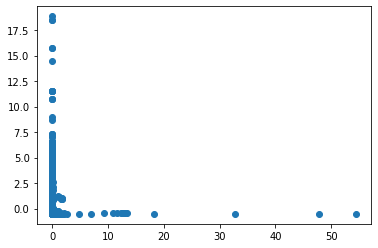

Logistic regression: 
coefficient of determination: 0.0004216811470855175
slope: [[-0.02053488]]
Correlation: 
                Tot_Srvcs  Avg_Sbmtd_Chrg
Tot_Srvcs        1.000000       -0.020535
Avg_Sbmtd_Chrg  -0.020535        1.000000
Analysis of Tot_Srvcs and Avg_Mdcr_Alowd_Amt
Scatter plot: 


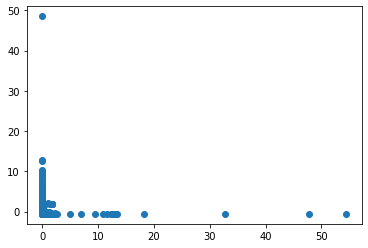

Logistic regression: 
coefficient of determination: 0.00048349186514862197
slope: [[-0.02198845]]
Correlation: 
                    Tot_Srvcs  Avg_Mdcr_Alowd_Amt
Tot_Srvcs            1.000000           -0.021988
Avg_Mdcr_Alowd_Amt  -0.021988            1.000000
Analysis of Tot_Srvcs and Avg_Mdcr_Pymt_Amt
Scatter plot: 


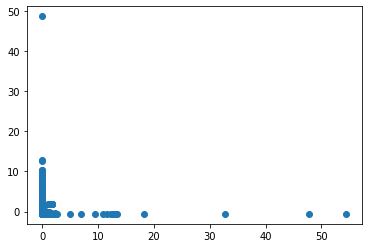

Logistic regression: 
coefficient of determination: 0.00047334814910826584
slope: [[-0.02175657]]
Correlation: 
                   Tot_Srvcs  Avg_Mdcr_Pymt_Amt
Tot_Srvcs           1.000000          -0.021757
Avg_Mdcr_Pymt_Amt  -0.021757           1.000000
Analysis of Tot_Srvcs and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


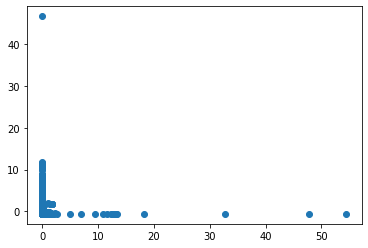

Logistic regression: 
coefficient of determination: 0.00046868571434421913
slope: [[-0.02164915]]
Correlation: 
                    Tot_Srvcs  Avg_Mdcr_Stdzd_Amt
Tot_Srvcs            1.000000           -0.021649
Avg_Mdcr_Stdzd_Amt  -0.021649            1.000000
Analysis of Tot_Srvcs and year
Scatter plot: 


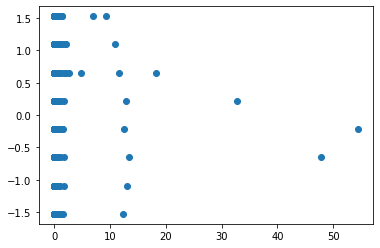

Logistic regression: 
coefficient of determination: 4.853615702793412e-06
slope: [[-0.00220309]]
Correlation: 
           Tot_Srvcs      year
Tot_Srvcs   1.000000 -0.002203
year       -0.002203  1.000000
Analysis of Tot_Bene_Day_Srvcs and Avg_Sbmtd_Chrg
Scatter plot: 


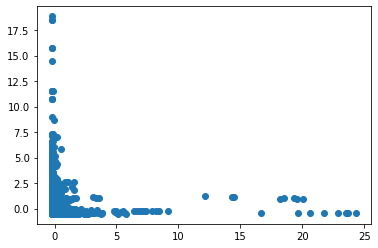

Logistic regression: 
coefficient of determination: 0.00026314539784400015
slope: [[-0.01622176]]
Correlation: 
                    Tot_Bene_Day_Srvcs  Avg_Sbmtd_Chrg
Tot_Bene_Day_Srvcs            1.000000       -0.016222
Avg_Sbmtd_Chrg               -0.016222        1.000000
Analysis of Tot_Bene_Day_Srvcs and Avg_Mdcr_Alowd_Amt
Scatter plot: 


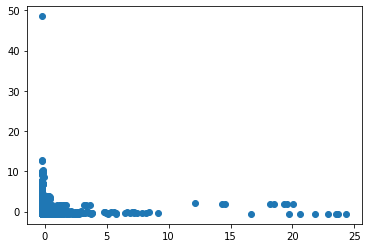

Logistic regression: 
coefficient of determination: 4.1003055384347675e-07
slope: [[-0.00064034]]
Correlation: 
                    Tot_Bene_Day_Srvcs  Avg_Mdcr_Alowd_Amt
Tot_Bene_Day_Srvcs             1.00000            -0.00064
Avg_Mdcr_Alowd_Amt            -0.00064             1.00000
Analysis of Tot_Bene_Day_Srvcs and Avg_Mdcr_Pymt_Amt
Scatter plot: 


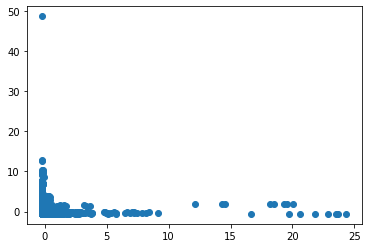

Logistic regression: 
coefficient of determination: 6.101999525109925e-06
slope: [[-0.00247022]]
Correlation: 
                    Tot_Bene_Day_Srvcs  Avg_Mdcr_Pymt_Amt
Tot_Bene_Day_Srvcs             1.00000           -0.00247
Avg_Mdcr_Pymt_Amt             -0.00247            1.00000
Analysis of Tot_Bene_Day_Srvcs and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


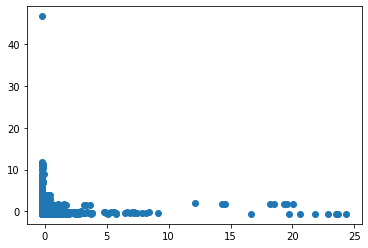

Logistic regression: 
coefficient of determination: 9.725107590230486e-06
slope: [[-0.00311851]]
Correlation: 
                    Tot_Bene_Day_Srvcs  Avg_Mdcr_Stdzd_Amt
Tot_Bene_Day_Srvcs            1.000000           -0.003119
Avg_Mdcr_Stdzd_Amt           -0.003119            1.000000
Analysis of Tot_Bene_Day_Srvcs and year
Scatter plot: 


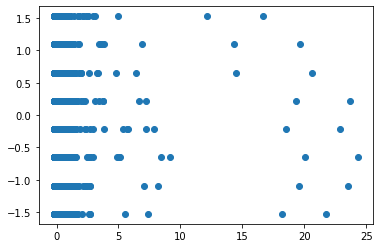

Logistic regression: 
coefficient of determination: 0.0003264858915964508
slope: [[-0.01806892]]
Correlation: 
                    Tot_Bene_Day_Srvcs      year
Tot_Bene_Day_Srvcs            1.000000 -0.018069
year                         -0.018069  1.000000
Analysis of Avg_Sbmtd_Chrg and Avg_Mdcr_Alowd_Amt
Scatter plot: 


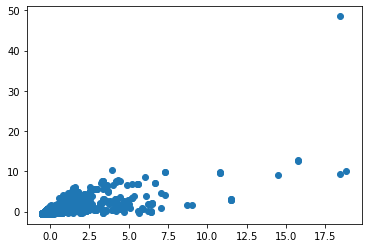

Logistic regression: 
coefficient of determination: 0.5573996635699502
slope: [[0.74659203]]
Correlation: 
                    Avg_Sbmtd_Chrg  Avg_Mdcr_Alowd_Amt
Avg_Sbmtd_Chrg            1.000000            0.746592
Avg_Mdcr_Alowd_Amt        0.746592            1.000000
Analysis of Avg_Sbmtd_Chrg and Avg_Mdcr_Pymt_Amt
Scatter plot: 


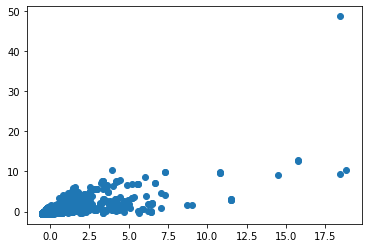

Logistic regression: 
coefficient of determination: 0.5536695951062328
slope: [[0.74408978]]
Correlation: 
                   Avg_Sbmtd_Chrg  Avg_Mdcr_Pymt_Amt
Avg_Sbmtd_Chrg            1.00000            0.74409
Avg_Mdcr_Pymt_Amt         0.74409            1.00000
Analysis of Avg_Sbmtd_Chrg and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


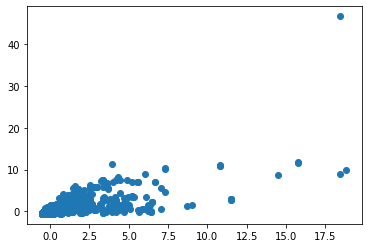

Logistic regression: 
coefficient of determination: 0.5449057849906942
slope: [[0.73817734]]
Correlation: 
                    Avg_Sbmtd_Chrg  Avg_Mdcr_Stdzd_Amt
Avg_Sbmtd_Chrg            1.000000            0.738177
Avg_Mdcr_Stdzd_Amt        0.738177            1.000000
Analysis of Avg_Sbmtd_Chrg and year
Scatter plot: 


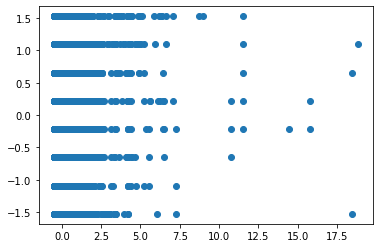

Logistic regression: 
coefficient of determination: 0.0009080829282880343
slope: [[0.03013441]]
Correlation: 
                Avg_Sbmtd_Chrg      year
Avg_Sbmtd_Chrg        1.000000  0.030134
year                  0.030134  1.000000
Analysis of Avg_Mdcr_Alowd_Amt and Avg_Mdcr_Pymt_Amt
Scatter plot: 


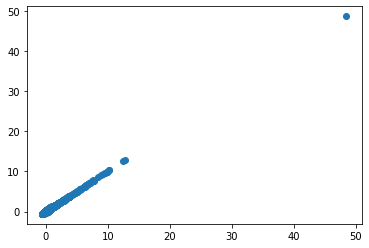

Logistic regression: 
coefficient of determination: 0.9970299786166175
slope: [[0.99851389]]
Correlation: 
                    Avg_Mdcr_Alowd_Amt  Avg_Mdcr_Pymt_Amt
Avg_Mdcr_Alowd_Amt            1.000000           0.998514
Avg_Mdcr_Pymt_Amt             0.998514           1.000000
Analysis of Avg_Mdcr_Alowd_Amt and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


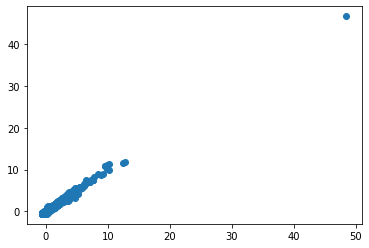

Logistic regression: 
coefficient of determination: 0.9883503734369781
slope: [[0.99415812]]
Correlation: 
                    Avg_Mdcr_Alowd_Amt  Avg_Mdcr_Stdzd_Amt
Avg_Mdcr_Alowd_Amt            1.000000            0.994158
Avg_Mdcr_Stdzd_Amt            0.994158            1.000000
Analysis of Avg_Mdcr_Alowd_Amt and year
Scatter plot: 


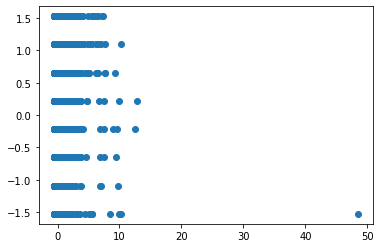

Logistic regression: 
coefficient of determination: 8.663099125039153e-05
slope: [[0.00930758]]
Correlation: 
                    Avg_Mdcr_Alowd_Amt      year
Avg_Mdcr_Alowd_Amt            1.000000  0.009308
year                          0.009308  1.000000
Analysis of Avg_Mdcr_Pymt_Amt and Avg_Mdcr_Stdzd_Amt
Scatter plot: 


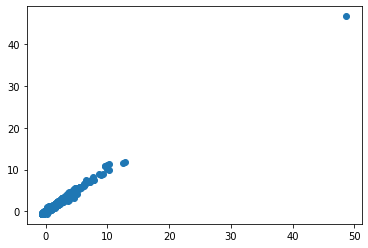

Logistic regression: 
coefficient of determination: 0.9912410787838744
slope: [[0.99561091]]
Correlation: 
                    Avg_Mdcr_Pymt_Amt  Avg_Mdcr_Stdzd_Amt
Avg_Mdcr_Pymt_Amt            1.000000            0.995611
Avg_Mdcr_Stdzd_Amt           0.995611            1.000000
Analysis of Avg_Mdcr_Pymt_Amt and year
Scatter plot: 


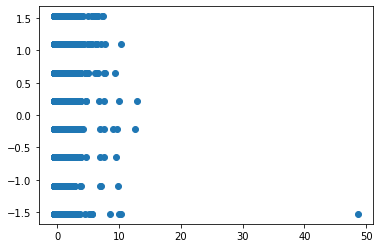

Logistic regression: 
coefficient of determination: 5.577580054727527e-05
slope: [[0.00746832]]
Correlation: 
                   Avg_Mdcr_Pymt_Amt      year
Avg_Mdcr_Pymt_Amt           1.000000  0.007468
year                        0.007468  1.000000
Analysis of Avg_Mdcr_Stdzd_Amt and year
Scatter plot: 


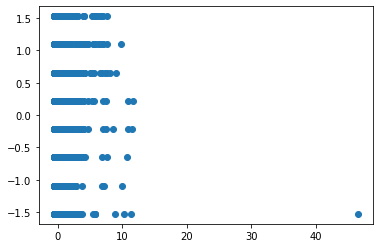

Logistic regression: 
coefficient of determination: 3.1274514904366946e-05
slope: [[0.00559236]]
Correlation: 
                    Avg_Mdcr_Stdzd_Amt      year
Avg_Mdcr_Stdzd_Amt            1.000000  0.005592
year                          0.005592  1.000000


In [35]:
columns = ["Rndrng_Prvdr_State_FIPS","Rndrng_Prvdr_Zip5","Rndrng_Prvdr_RUCA","HCPCS_Drug_Ind","Place_Of_Srvc","Tot_Benes","Tot_Srvcs","Tot_Bene_Day_Srvcs","Avg_Sbmtd_Chrg","Avg_Mdcr_Alowd_Amt","Avg_Mdcr_Pymt_Amt","Avg_Mdcr_Stdzd_Amt","year"]
dummys = ["HCPCS_Drug_Ind","Place_Of_Srvc"]
for pos, column1 in enumerate(columns):
    for column2 in columns[pos + 1:]:
        print("Analysis of " + column1 + " and " + column2)
        df = ph_df.copy()
        if not((column1 in dummys) or (column2 in dummys)):
            df[column1] = stats.zscore(df[column1])
            df[column2] = stats.zscore(df[column2])
        
        print("Scatter plot: ")
        plt.scatter(df[column1], df[column2])
        plt.show()
        print("Logistic regression: ")
        model = LinearRegression()
        x = df[[column1]]
        y = df[[column2]]
        model.fit(x, y)
        r_sq = model.score(x, y)
        print(f"coefficient of determination: {r_sq}")
        print(f"slope: {model.coef_}")
        corr_df = df[[column1,column2]]
        print("Correlation: ")
        print(corr_df.corr())
        
        



### Comparisons of note:

#### Analysis of Tot_Srvcs and Tot_Bene_Day_Srvcs \n
#### Avg_Sbmtd_Chrg and Avg_Mdcr_Alowd_Amt \n
#### Avg_Sbmtd_Chrg and Avg_Mdcr_Pymt_Amt
#### Avg_Sbmtd_Chrg and Avg_Mdcr_Stdzd_Amt

### Prescribers DB bivariant analysis

In [18]:
prescribers.dtypes

Unnamed: 0                 int64
Prscrbr_NPI                int64
Prscrbr_Last_Org_Name     object
Prscrbr_First_Name        object
Prscrbr_City              object
Prscrbr_State_Abrvtn      object
Prscrbr_State_FIPS         int64
Prscrbr_Type              object
Prscrbr_Type_Src          object
Brnd_Name                 object
Gnrc_Name                 object
Tot_Clms                   int64
Tot_30day_Fills          float64
Tot_Day_Suply              int64
Tot_Drug_Cst             float64
Tot_Benes                float64
GE65_Sprsn_Flag           object
GE65_Tot_Clms            float64
GE65_Tot_30day_Fills     float64
GE65_Tot_Drug_Cst        float64
GE65_Tot_Day_Suply       float64
GE65_Bene_Sprsn_Flag      object
GE65_Tot_Benes           float64
year                       int64
dtype: object

In [45]:
ps_df = prescribers[[
'Prscrbr_Type_Src',
'Tot_Clms',
'Tot_30day_Fills',
'Tot_Day_Suply',
'Tot_Drug_Cst',
'Tot_Benes',
'GE65_Sprsn_Flag',
'GE65_Tot_Clms',
'GE65_Tot_30day_Fills',
'GE65_Tot_Drug_Cst',
'GE65_Tot_Day_Suply',
'GE65_Bene_Sprsn_Flag',
'GE65_Tot_Benes',
'year']]

ps_df.head()

,Prscrbr_Type_Src,Tot_Clms,Tot_30day_Fills,Tot_Day_Suply,Tot_Drug_Cst,Tot_Benes,GE65_Sprsn_Flag,GE65_Tot_Clms,GE65_Tot_30day_Fills,GE65_Tot_Drug_Cst,GE65_Tot_Day_Suply,GE65_Bene_Sprsn_Flag,GE65_Tot_Benes,year
0,S,13,13.8,399,135.38,NaN,NaN,13.0,13.8,135.38,399.0,*,NaN,2020
1,S,13,19.0,570,42.47,NaN,*,NaN,NaN,NaN,NaN,*,NaN,2020
2,S,16,18.0,540,494.38,NaN,NaN,16.0,18.0,494.38,540.0,*,NaN,2020
3,S,11,12.0,323,4792.85,NaN,*,NaN,NaN,NaN,NaN,*,NaN,2020
4,S,16,18.0,523,162.09,NaN,#,NaN,NaN,NaN,NaN,*,NaN,2020


### Find object types that can be converted to discrete numeric

In [46]:
#print(set(ps_df["Prscrbr_Type"]))
print(set(ps_df["Prscrbr_Type_Src"]))
#print(set(ps_df["Brnd_Name"]))
#print(set(ps_df["Gnrc_Name"]))
print(set(ps_df["GE65_Sprsn_Flag"]))
print(set(ps_df["GE65_Bene_Sprsn_Flag"]))

ps_df["Prscrbr_Type_Src"].replace(['S', 'T'],[0,1],inplace=True)
ps_df["GE65_Sprsn_Flag"].replace(['*', '#'],[0,1],inplace=True)
ps_df["GE65_Bene_Sprsn_Flag"].replace(['*', '#'],[0,1],inplace=True)



{'S', 'T'}
{nan, '*', '#'}
{nan, '*', '#'}


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [47]:
ps_df.dtypes

Prscrbr_Type_Src          int64
Tot_Clms                  int64
Tot_30day_Fills         float64
Tot_Day_Suply             int64
Tot_Drug_Cst            float64
Tot_Benes               float64
GE65_Sprsn_Flag         float64
GE65_Tot_Clms           float64
GE65_Tot_30day_Fills    float64
GE65_Tot_Drug_Cst       float64
GE65_Tot_Day_Suply      float64
GE65_Bene_Sprsn_Flag    float64
GE65_Tot_Benes          float64
year                      int64
dtype: object

### Run analysis for all possible pairs

Analysis of Prscrbr_Type_Src and Tot_Clms
Scatter plot: 


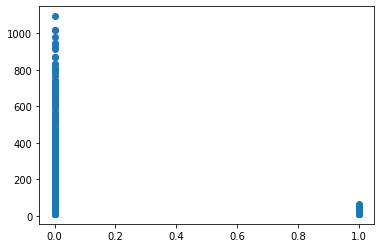

Logistic regression: 
coefficient of determination: 0.00125534985057274
slope: [[-33.42468279]]
Correlation: 
                  Prscrbr_Type_Src  Tot_Clms
Prscrbr_Type_Src          1.000000 -0.035431
Tot_Clms                 -0.035431  1.000000
Analysis of Prscrbr_Type_Src and Tot_30day_Fills
Scatter plot: 


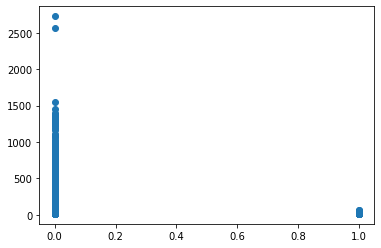

Logistic regression: 
coefficient of determination: 0.0016403348474481882
slope: [[-62.22556918]]
Correlation: 
                  Prscrbr_Type_Src  Tot_30day_Fills
Prscrbr_Type_Src          1.000000        -0.040501
Tot_30day_Fills          -0.040501         1.000000
Analysis of Prscrbr_Type_Src and Tot_Day_Suply
Scatter plot: 


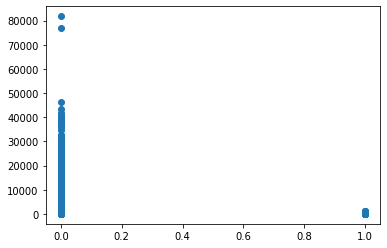

Logistic regression: 
coefficient of determination: 0.002368198725727466
slope: [[-2241.92179537]]
Correlation: 
                  Prscrbr_Type_Src  Tot_Day_Suply
Prscrbr_Type_Src          1.000000      -0.048664
Tot_Day_Suply            -0.048664       1.000000
Analysis of Prscrbr_Type_Src and Tot_Drug_Cst
Scatter plot: 


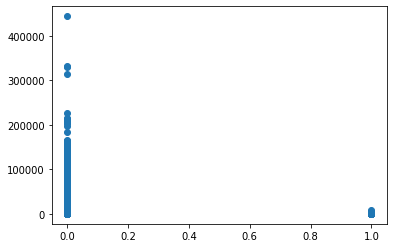

Logistic regression: 
coefficient of determination: 0.0006028640903490423
slope: [[-4396.9998002]]
Correlation: 
                  Prscrbr_Type_Src  Tot_Drug_Cst
Prscrbr_Type_Src          1.000000     -0.024553
Tot_Drug_Cst             -0.024553      1.000000
Analysis of Prscrbr_Type_Src and Tot_Benes
Scatter plot: 


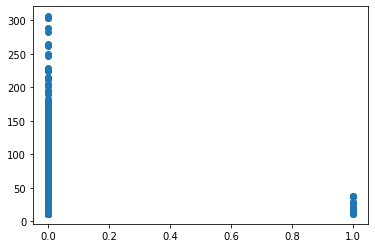

Logistic regression: 
coefficient of determination: 0.0017488777532662647
slope: [[-11.72261905]]
Correlation: 
                  Prscrbr_Type_Src  Tot_Benes
Prscrbr_Type_Src           1.00000   -0.04182
Tot_Benes                 -0.04182    1.00000
Analysis of Prscrbr_Type_Src and GE65_Sprsn_Flag
Scatter plot: 


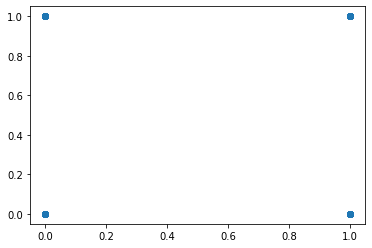

Logistic regression: 
coefficient of determination: 0.0017140895787137733
slope: [[0.16025641]]
Correlation: 
                  Prscrbr_Type_Src  GE65_Sprsn_Flag
Prscrbr_Type_Src          1.000000         0.041402
GE65_Sprsn_Flag           0.041402         1.000000
Analysis of Prscrbr_Type_Src and GE65_Tot_Clms
Scatter plot: 


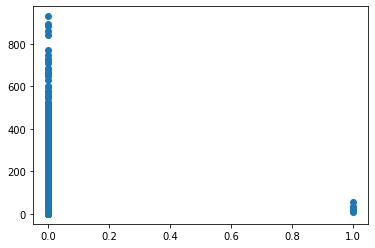

Logistic regression: 
coefficient of determination: 0.0006239314961826725
slope: [[-34.54749665]]
Correlation: 
                  Prscrbr_Type_Src  GE65_Tot_Clms
Prscrbr_Type_Src          1.000000      -0.024979
GE65_Tot_Clms            -0.024979       1.000000
Analysis of Prscrbr_Type_Src and GE65_Tot_30day_Fills
Scatter plot: 


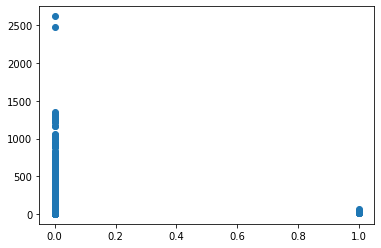

Logistic regression: 
coefficient of determination: 0.0007144175157951516
slope: [[-62.77367838]]
Correlation: 
                      Prscrbr_Type_Src  GE65_Tot_30day_Fills
Prscrbr_Type_Src              1.000000             -0.026729
GE65_Tot_30day_Fills         -0.026729              1.000000
Analysis of Prscrbr_Type_Src and GE65_Tot_Drug_Cst
Scatter plot: 


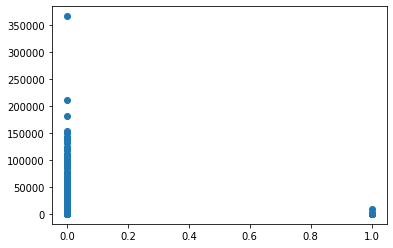

Logistic regression: 
coefficient of determination: 0.0002491797498869186
slope: [[-3417.38370414]]
Correlation: 
                   Prscrbr_Type_Src  GE65_Tot_Drug_Cst
Prscrbr_Type_Src           1.000000          -0.015785
GE65_Tot_Drug_Cst         -0.015785           1.000000
Analysis of Prscrbr_Type_Src and GE65_Tot_Day_Suply
Scatter plot: 


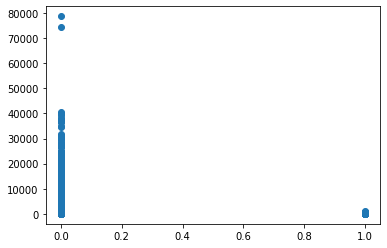

Logistic regression: 
coefficient of determination: 0.0009750210655237179
slope: [[-2195.72581454]]
Correlation: 
                    Prscrbr_Type_Src  GE65_Tot_Day_Suply
Prscrbr_Type_Src            1.000000           -0.031225
GE65_Tot_Day_Suply         -0.031225            1.000000
Analysis of Prscrbr_Type_Src and GE65_Bene_Sprsn_Flag
Scatter plot: 


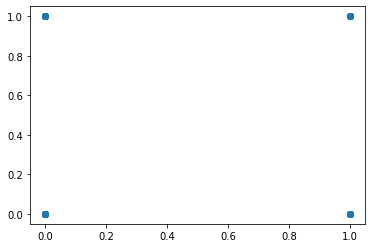

Logistic regression: 
coefficient of determination: 0.0014074065689303472
slope: [[0.18906163]]
Correlation: 
                      Prscrbr_Type_Src  GE65_Bene_Sprsn_Flag
Prscrbr_Type_Src              1.000000              0.037515
GE65_Bene_Sprsn_Flag          0.037515              1.000000
Analysis of Prscrbr_Type_Src and GE65_Tot_Benes
Scatter plot: 


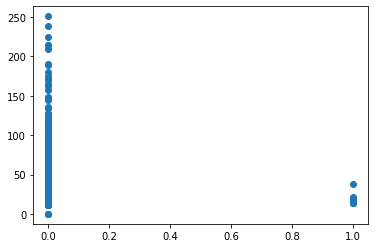

Logistic regression: 
coefficient of determination: 0.0021741502086138897
slope: [[-15.2810728]]
Correlation: 
                  Prscrbr_Type_Src  GE65_Tot_Benes
Prscrbr_Type_Src          1.000000       -0.046628
GE65_Tot_Benes           -0.046628        1.000000
Analysis of Prscrbr_Type_Src and year
Scatter plot: 


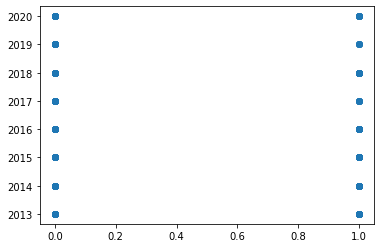

Logistic regression: 
coefficient of determination: 0.0006700141150428607
slope: [[-0.63237287]]
Correlation: 
                  Prscrbr_Type_Src      year
Prscrbr_Type_Src          1.000000 -0.025885
year                     -0.025885  1.000000
Analysis of Tot_Clms and Tot_30day_Fills
Scatter plot: 


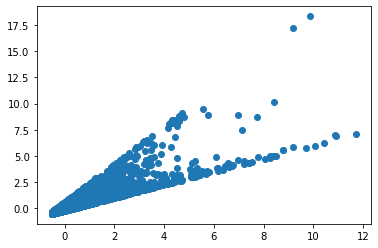

Logistic regression: 
coefficient of determination: 0.7824893878679304
slope: [[0.8845843]]
Correlation: 
                 Tot_Clms  Tot_30day_Fills
Tot_Clms         1.000000         0.884584
Tot_30day_Fills  0.884584         1.000000
Analysis of Tot_Clms and Tot_Day_Suply
Scatter plot: 


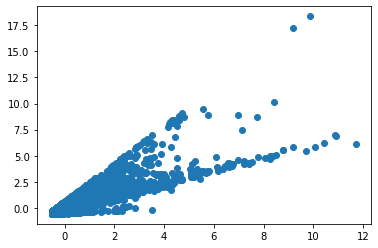

Logistic regression: 
coefficient of determination: 0.7562545668203696
slope: [[0.86962898]]
Correlation: 
               Tot_Clms  Tot_Day_Suply
Tot_Clms       1.000000       0.869629
Tot_Day_Suply  0.869629       1.000000
Analysis of Tot_Clms and Tot_Drug_Cst
Scatter plot: 


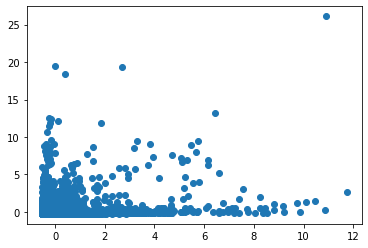

Logistic regression: 
coefficient of determination: 0.05259654669254277
slope: [[0.22933937]]
Correlation: 
              Tot_Clms  Tot_Drug_Cst
Tot_Clms      1.000000      0.229339
Tot_Drug_Cst  0.229339      1.000000
Analysis of Tot_Clms and Tot_Benes
Scatter plot: 


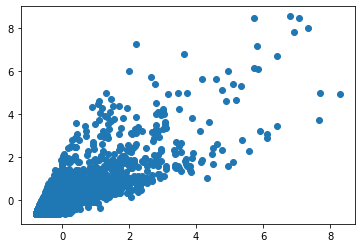

Logistic regression: 
coefficient of determination: 0.6747194719318779
slope: [[0.82141309]]
Correlation: 
           Tot_Clms  Tot_Benes
Tot_Clms   1.000000   0.821413
Tot_Benes  0.821413   1.000000
Analysis of Tot_Clms and GE65_Sprsn_Flag
Scatter plot: 


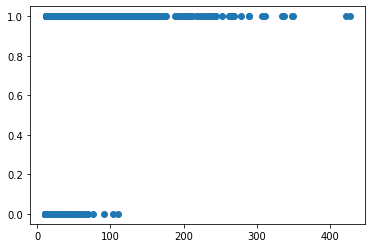

Logistic regression: 
coefficient of determination: 0.10790035345144677
slope: [[0.00412692]]
Correlation: 
                 Tot_Clms  GE65_Sprsn_Flag
Tot_Clms         1.000000         0.328482
GE65_Sprsn_Flag  0.328482         1.000000
Analysis of Tot_Clms and GE65_Tot_Clms
Scatter plot: 


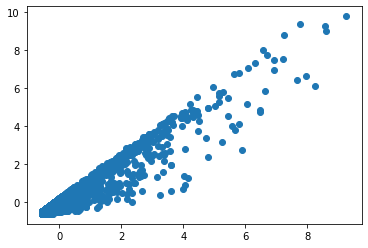

Logistic regression: 
coefficient of determination: 0.9203690128451915
slope: [[0.95935865]]
Correlation: 
               Tot_Clms  GE65_Tot_Clms
Tot_Clms       1.000000       0.959359
GE65_Tot_Clms  0.959359       1.000000
Analysis of Tot_Clms and GE65_Tot_30day_Fills
Scatter plot: 


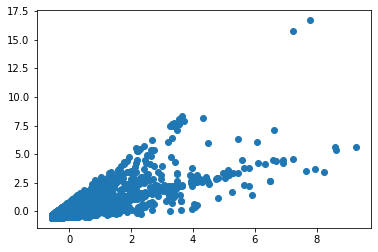

Logistic regression: 
coefficient of determination: 0.6786937767944903
slope: [[0.82382873]]
Correlation: 
                      Tot_Clms  GE65_Tot_30day_Fills
Tot_Clms              1.000000              0.823829
GE65_Tot_30day_Fills  0.823829              1.000000
Analysis of Tot_Clms and GE65_Tot_Drug_Cst
Scatter plot: 


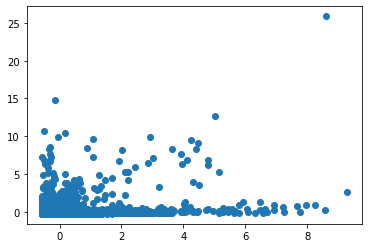

Logistic regression: 
coefficient of determination: 0.0630793725291029
slope: [[0.25115607]]
Correlation: 
                   Tot_Clms  GE65_Tot_Drug_Cst
Tot_Clms           1.000000           0.251156
GE65_Tot_Drug_Cst  0.251156           1.000000
Analysis of Tot_Clms and GE65_Tot_Day_Suply
Scatter plot: 


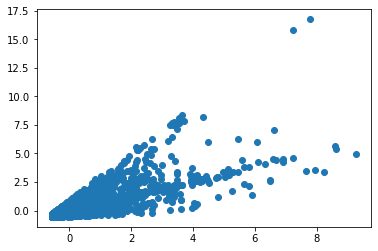

Logistic regression: 
coefficient of determination: 0.6606553474040415
slope: [[0.81280708]]
Correlation: 
                    Tot_Clms  GE65_Tot_Day_Suply
Tot_Clms            1.000000            0.812807
GE65_Tot_Day_Suply  0.812807            1.000000
Analysis of Tot_Clms and GE65_Bene_Sprsn_Flag
Scatter plot: 


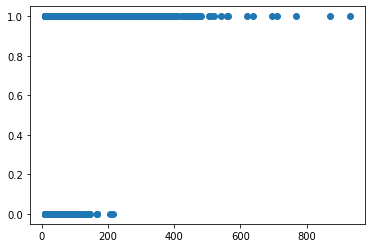

Logistic regression: 
coefficient of determination: 0.25645591438015725
slope: [[0.00362236]]
Correlation: 
                      Tot_Clms  GE65_Bene_Sprsn_Flag
Tot_Clms              1.000000              0.506415
GE65_Bene_Sprsn_Flag  0.506415              1.000000
Analysis of Tot_Clms and GE65_Tot_Benes
Scatter plot: 


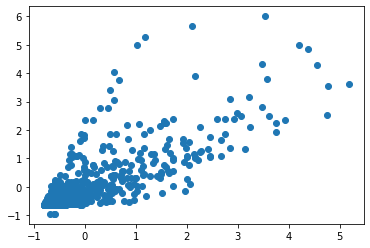

Logistic regression: 
coefficient of determination: 0.622170385648056
slope: [[0.78877778]]
Correlation: 
                Tot_Clms  GE65_Tot_Benes
Tot_Clms        1.000000        0.788778
GE65_Tot_Benes  0.788778        1.000000
Analysis of Tot_Clms and year
Scatter plot: 


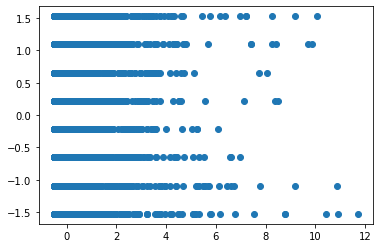

Logistic regression: 
coefficient of determination: 4.274262823233954e-06
slope: [[0.00206743]]
Correlation: 
          Tot_Clms      year
Tot_Clms  1.000000  0.002067
year      0.002067  1.000000
Analysis of Tot_30day_Fills and Tot_Day_Suply
Scatter plot: 


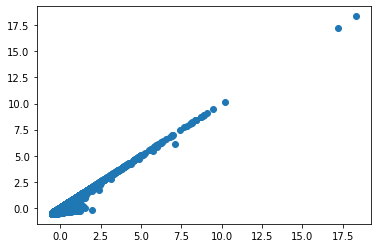

Logistic regression: 
coefficient of determination: 0.9912079741926473
slope: [[0.99559428]]
Correlation: 
                 Tot_30day_Fills  Tot_Day_Suply
Tot_30day_Fills         1.000000       0.995594
Tot_Day_Suply           0.995594       1.000000
Analysis of Tot_30day_Fills and Tot_Drug_Cst
Scatter plot: 


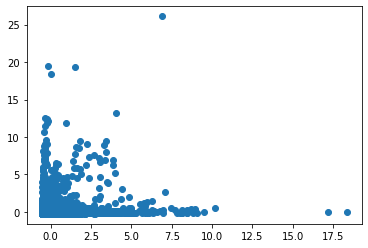

Logistic regression: 
coefficient of determination: 0.017586952062332184
slope: [[0.13261581]]
Correlation: 
                 Tot_30day_Fills  Tot_Drug_Cst
Tot_30day_Fills         1.000000      0.132616
Tot_Drug_Cst            0.132616      1.000000
Analysis of Tot_30day_Fills and Tot_Benes
Scatter plot: 


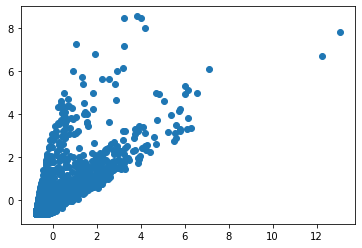

Logistic regression: 
coefficient of determination: 0.5541756468426049
slope: [[0.74442975]]
Correlation: 
                 Tot_30day_Fills  Tot_Benes
Tot_30day_Fills          1.00000    0.74443
Tot_Benes                0.74443    1.00000
Analysis of Tot_30day_Fills and GE65_Sprsn_Flag
Scatter plot: 


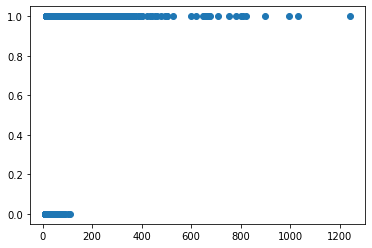

Logistic regression: 
coefficient of determination: 0.08875377620668401
slope: [[0.00170534]]
Correlation: 
                 Tot_30day_Fills  GE65_Sprsn_Flag
Tot_30day_Fills         1.000000         0.297916
GE65_Sprsn_Flag         0.297916         1.000000
Analysis of Tot_30day_Fills and GE65_Tot_Clms
Scatter plot: 


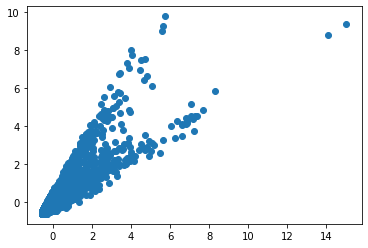

Logistic regression: 
coefficient of determination: 0.786505409522816
slope: [[0.8868514]]
Correlation: 
                 Tot_30day_Fills  GE65_Tot_Clms
Tot_30day_Fills         1.000000       0.886851
GE65_Tot_Clms           0.886851       1.000000
Analysis of Tot_30day_Fills and GE65_Tot_30day_Fills
Scatter plot: 


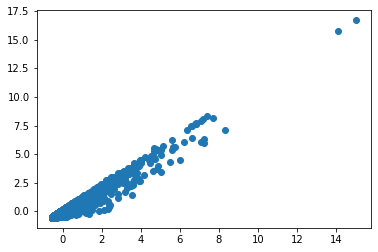

Logistic regression: 
coefficient of determination: 0.9555812783837945
slope: [[0.97753838]]
Correlation: 
                      Tot_30day_Fills  GE65_Tot_30day_Fills
Tot_30day_Fills              1.000000              0.977538
GE65_Tot_30day_Fills         0.977538              1.000000
Analysis of Tot_30day_Fills and GE65_Tot_Drug_Cst
Scatter plot: 


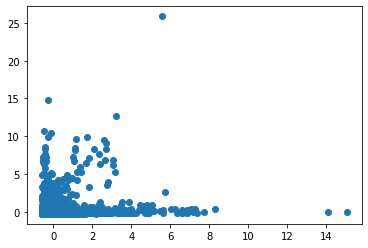

Logistic regression: 
coefficient of determination: 0.023948495942202386
slope: [[0.15475302]]
Correlation: 
                   Tot_30day_Fills  GE65_Tot_Drug_Cst
Tot_30day_Fills           1.000000           0.154753
GE65_Tot_Drug_Cst         0.154753           1.000000
Analysis of Tot_30day_Fills and GE65_Tot_Day_Suply
Scatter plot: 


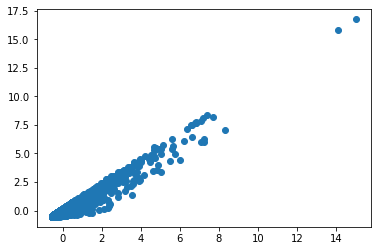

Logistic regression: 
coefficient of determination: 0.9492917964125942
slope: [[0.97431607]]
Correlation: 
                    Tot_30day_Fills  GE65_Tot_Day_Suply
Tot_30day_Fills            1.000000            0.974316
GE65_Tot_Day_Suply         0.974316            1.000000
Analysis of Tot_30day_Fills and GE65_Bene_Sprsn_Flag
Scatter plot: 


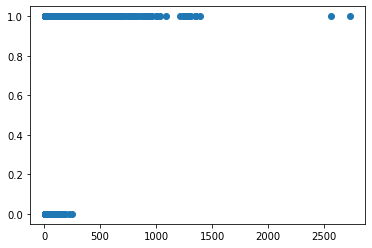

Logistic regression: 
coefficient of determination: 0.21289813837750482
slope: [[0.00173533]]
Correlation: 
                      Tot_30day_Fills  GE65_Bene_Sprsn_Flag
Tot_30day_Fills              1.000000              0.461409
GE65_Bene_Sprsn_Flag         0.461409              1.000000
Analysis of Tot_30day_Fills and GE65_Tot_Benes
Scatter plot: 


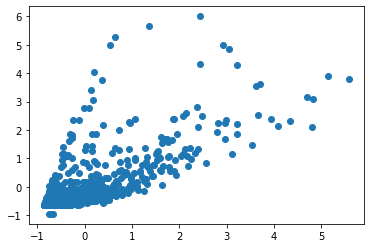

Logistic regression: 
coefficient of determination: 0.5373031284703043
slope: [[0.73300964]]
Correlation: 
                 Tot_30day_Fills  GE65_Tot_Benes
Tot_30day_Fills          1.00000         0.73301
GE65_Tot_Benes           0.73301         1.00000
Analysis of Tot_30day_Fills and year
Scatter plot: 


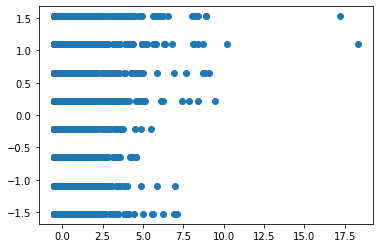

Logistic regression: 
coefficient of determination: 0.006622646346334804
slope: [[0.08137964]]
Correlation: 
                 Tot_30day_Fills     year
Tot_30day_Fills          1.00000  0.08138
year                     0.08138  1.00000
Analysis of Tot_Day_Suply and Tot_Drug_Cst
Scatter plot: 


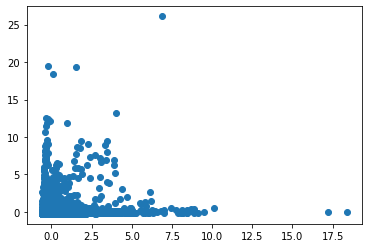

Logistic regression: 
coefficient of determination: 0.018514485276147852
slope: [[0.13606794]]
Correlation: 
               Tot_Day_Suply  Tot_Drug_Cst
Tot_Day_Suply       1.000000      0.136068
Tot_Drug_Cst        0.136068      1.000000
Analysis of Tot_Day_Suply and Tot_Benes
Scatter plot: 


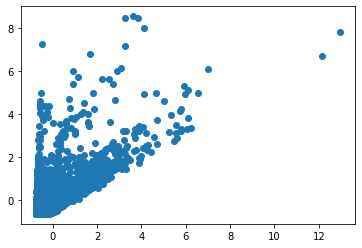

Logistic regression: 
coefficient of determination: 0.48898907687670445
slope: [[0.69927754]]
Correlation: 
               Tot_Day_Suply  Tot_Benes
Tot_Day_Suply       1.000000   0.699278
Tot_Benes           0.699278   1.000000
Analysis of Tot_Day_Suply and GE65_Sprsn_Flag
Scatter plot: 


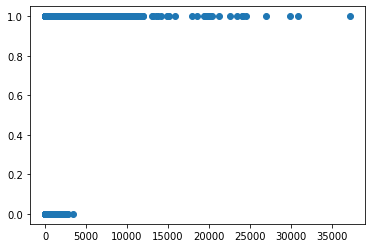

Logistic regression: 
coefficient of determination: 0.07627430055277895
slope: [[5.22691719e-05]]
Correlation: 
                 Tot_Day_Suply  GE65_Sprsn_Flag
Tot_Day_Suply         1.000000         0.276178
GE65_Sprsn_Flag       0.276178         1.000000
Analysis of Tot_Day_Suply and GE65_Tot_Clms
Scatter plot: 


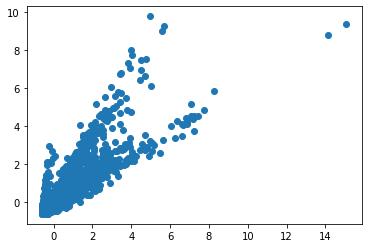

Logistic regression: 
coefficient of determination: 0.7653456115793251
slope: [[0.87484033]]
Correlation: 
               Tot_Day_Suply  GE65_Tot_Clms
Tot_Day_Suply        1.00000        0.87484
GE65_Tot_Clms        0.87484        1.00000
Analysis of Tot_Day_Suply and GE65_Tot_30day_Fills
Scatter plot: 


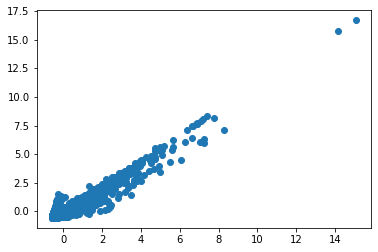

Logistic regression: 
coefficient of determination: 0.950195965192332
slope: [[0.97477996]]
Correlation: 
                      Tot_Day_Suply  GE65_Tot_30day_Fills
Tot_Day_Suply               1.00000               0.97478
GE65_Tot_30day_Fills        0.97478               1.00000
Analysis of Tot_Day_Suply and GE65_Tot_Drug_Cst
Scatter plot: 


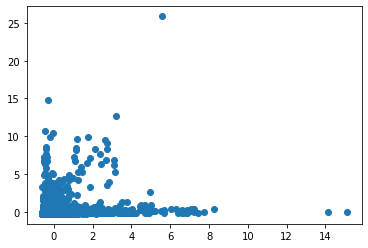

Logistic regression: 
coefficient of determination: 0.024569669480369316
slope: [[0.15674715]]
Correlation: 
                   Tot_Day_Suply  GE65_Tot_Drug_Cst
Tot_Day_Suply           1.000000           0.156747
GE65_Tot_Drug_Cst       0.156747           1.000000
Analysis of Tot_Day_Suply and GE65_Tot_Day_Suply
Scatter plot: 


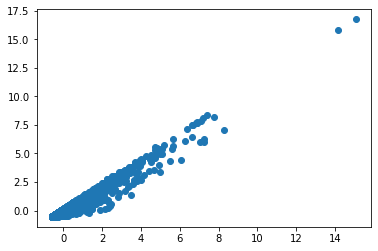

Logistic regression: 
coefficient of determination: 0.9570901380513923
slope: [[0.97830984]]
Correlation: 
                    Tot_Day_Suply  GE65_Tot_Day_Suply
Tot_Day_Suply             1.00000             0.97831
GE65_Tot_Day_Suply        0.97831             1.00000
Analysis of Tot_Day_Suply and GE65_Bene_Sprsn_Flag
Scatter plot: 


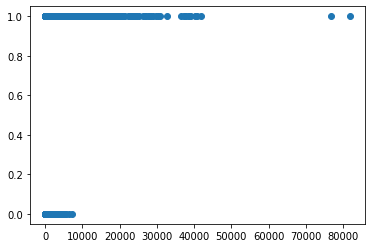

Logistic regression: 
coefficient of determination: 0.1945091330707842
slope: [[5.51512079e-05]]
Correlation: 
                      Tot_Day_Suply  GE65_Bene_Sprsn_Flag
Tot_Day_Suply              1.000000              0.441032
GE65_Bene_Sprsn_Flag       0.441032              1.000000
Analysis of Tot_Day_Suply and GE65_Tot_Benes
Scatter plot: 


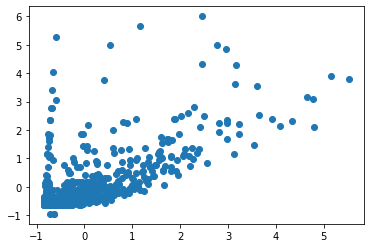

Logistic regression: 
coefficient of determination: 0.4573397536060173
slope: [[0.676269]]
Correlation: 
                Tot_Day_Suply  GE65_Tot_Benes
Tot_Day_Suply        1.000000        0.676269
GE65_Tot_Benes       0.676269        1.000000
Analysis of Tot_Day_Suply and year
Scatter plot: 


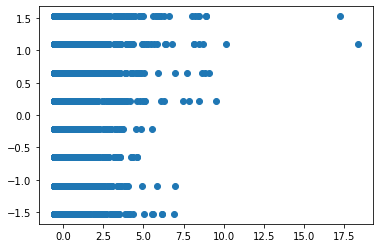

Logistic regression: 
coefficient of determination: 0.005637908776951028
slope: [[0.07508601]]
Correlation: 
               Tot_Day_Suply      year
Tot_Day_Suply       1.000000  0.075086
year                0.075086  1.000000
Analysis of Tot_Drug_Cst and Tot_Benes
Scatter plot: 


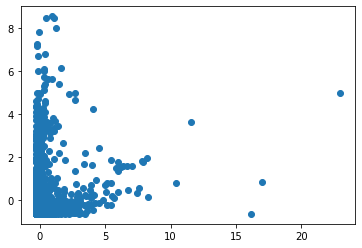

Logistic regression: 
coefficient of determination: 0.029652784584434322
slope: [[0.17219984]]
Correlation: 
              Tot_Drug_Cst  Tot_Benes
Tot_Drug_Cst        1.0000     0.1722
Tot_Benes           0.1722     1.0000
Analysis of Tot_Drug_Cst and GE65_Sprsn_Flag
Scatter plot: 


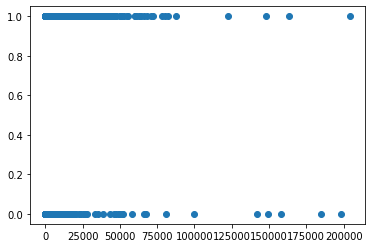

Logistic regression: 
coefficient of determination: 0.00010228455501037903
slope: [[4.129746e-07]]
Correlation: 
                 Tot_Drug_Cst  GE65_Sprsn_Flag
Tot_Drug_Cst         1.000000         0.010114
GE65_Sprsn_Flag      0.010114         1.000000
Analysis of Tot_Drug_Cst and GE65_Tot_Clms
Scatter plot: 


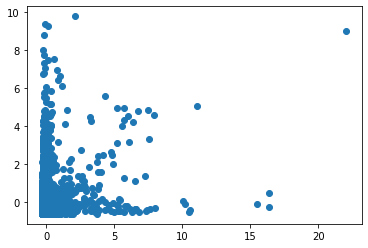

Logistic regression: 
coefficient of determination: 0.04287250034863144
slope: [[0.20705676]]
Correlation: 
               Tot_Drug_Cst  GE65_Tot_Clms
Tot_Drug_Cst       1.000000       0.207057
GE65_Tot_Clms      0.207057       1.000000
Analysis of Tot_Drug_Cst and GE65_Tot_30day_Fills
Scatter plot: 


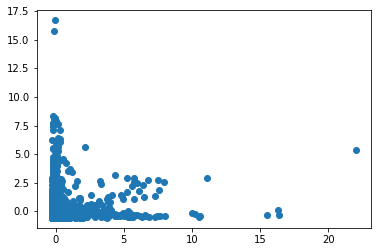

Logistic regression: 
coefficient of determination: 0.011421456293130627
slope: [[0.10687121]]
Correlation: 
                      Tot_Drug_Cst  GE65_Tot_30day_Fills
Tot_Drug_Cst              1.000000              0.106871
GE65_Tot_30day_Fills      0.106871              1.000000
Analysis of Tot_Drug_Cst and GE65_Tot_Drug_Cst
Scatter plot: 


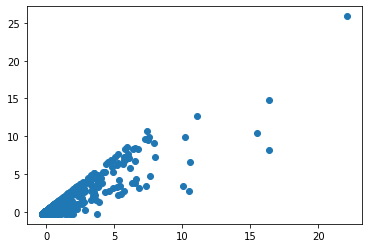

Logistic regression: 
coefficient of determination: 0.8622421861578244
slope: [[0.92856997]]
Correlation: 
                   Tot_Drug_Cst  GE65_Tot_Drug_Cst
Tot_Drug_Cst            1.00000            0.92857
GE65_Tot_Drug_Cst       0.92857            1.00000
Analysis of Tot_Drug_Cst and GE65_Tot_Day_Suply
Scatter plot: 


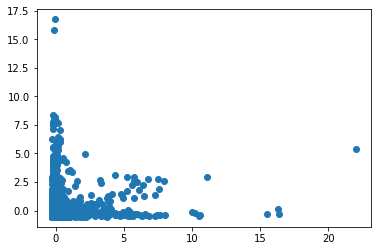

Logistic regression: 
coefficient of determination: 0.011899068845640737
slope: [[0.10908285]]
Correlation: 
                    Tot_Drug_Cst  GE65_Tot_Day_Suply
Tot_Drug_Cst            1.000000            0.109083
GE65_Tot_Day_Suply      0.109083            1.000000
Analysis of Tot_Drug_Cst and GE65_Bene_Sprsn_Flag
Scatter plot: 


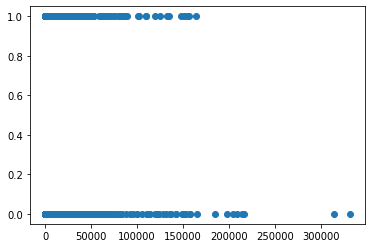

Logistic regression: 
coefficient of determination: 0.0006974561767844056
slope: [[8.24893569e-07]]
Correlation: 
                      Tot_Drug_Cst  GE65_Bene_Sprsn_Flag
Tot_Drug_Cst              1.000000              0.026409
GE65_Bene_Sprsn_Flag      0.026409              1.000000
Analysis of Tot_Drug_Cst and GE65_Tot_Benes
Scatter plot: 


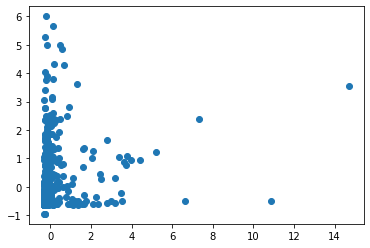

Logistic regression: 
coefficient of determination: 0.03989112754448276
slope: [[0.19972763]]
Correlation: 
                Tot_Drug_Cst  GE65_Tot_Benes
Tot_Drug_Cst        1.000000        0.199728
GE65_Tot_Benes      0.199728        1.000000
Analysis of Tot_Drug_Cst and year
Scatter plot: 


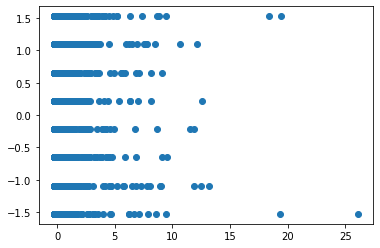

Logistic regression: 
coefficient of determination: 4.0967775969735776e-05
slope: [[0.00640061]]
Correlation: 
              Tot_Drug_Cst      year
Tot_Drug_Cst      1.000000  0.006401
year              0.006401  1.000000
Analysis of Tot_Benes and GE65_Sprsn_Flag
Scatter plot: 


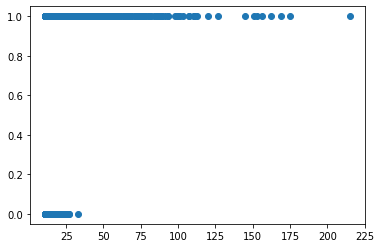

Logistic regression: 
coefficient of determination: 0.04236856989557758
slope: [[0.00364886]]
Correlation: 
                 Tot_Benes  GE65_Sprsn_Flag
Tot_Benes         1.000000         0.205836
GE65_Sprsn_Flag   0.205836         1.000000
Analysis of Tot_Benes and GE65_Tot_Clms
Scatter plot: 


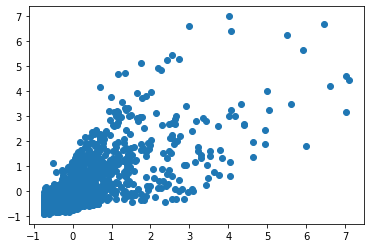

Logistic regression: 
coefficient of determination: 0.5688092402823656
slope: [[0.75419443]]
Correlation: 
               Tot_Benes  GE65_Tot_Clms
Tot_Benes       1.000000       0.754194
GE65_Tot_Clms   0.754194       1.000000
Analysis of Tot_Benes and GE65_Tot_30day_Fills
Scatter plot: 


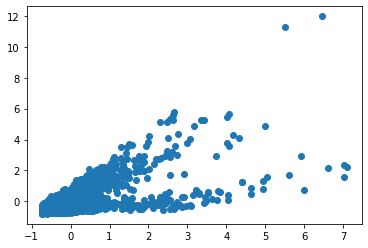

Logistic regression: 
coefficient of determination: 0.46470248401419967
slope: [[0.6816909]]
Correlation: 
                      Tot_Benes  GE65_Tot_30day_Fills
Tot_Benes              1.000000              0.681691
GE65_Tot_30day_Fills   0.681691              1.000000
Analysis of Tot_Benes and GE65_Tot_Drug_Cst
Scatter plot: 


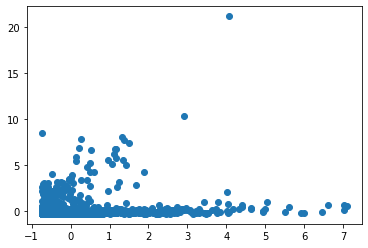

Logistic regression: 
coefficient of determination: 0.027296030263070814
slope: [[0.1652151]]
Correlation: 
                   Tot_Benes  GE65_Tot_Drug_Cst
Tot_Benes           1.000000           0.165215
GE65_Tot_Drug_Cst   0.165215           1.000000
Analysis of Tot_Benes and GE65_Tot_Day_Suply
Scatter plot: 


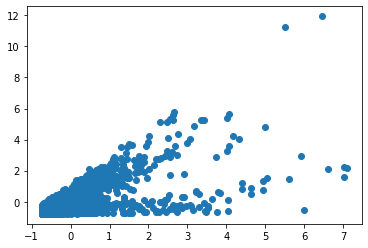

Logistic regression: 
coefficient of determination: 0.4196274728961227
slope: [[0.6477866]]
Correlation: 
                    Tot_Benes  GE65_Tot_Day_Suply
Tot_Benes            1.000000            0.647787
GE65_Tot_Day_Suply   0.647787            1.000000
Analysis of Tot_Benes and GE65_Bene_Sprsn_Flag
Scatter plot: 


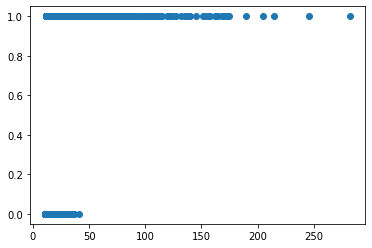

Logistic regression: 
coefficient of determination: 0.12231383970161214
slope: [[0.00664801]]
Correlation: 
                      Tot_Benes  GE65_Bene_Sprsn_Flag
Tot_Benes              1.000000              0.349734
GE65_Bene_Sprsn_Flag   0.349734              1.000000
Analysis of Tot_Benes and GE65_Tot_Benes
Scatter plot: 


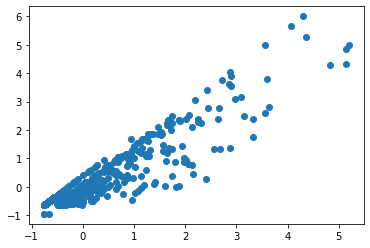

Logistic regression: 
coefficient of determination: 0.8614609622450751
slope: [[0.92814921]]
Correlation: 
                Tot_Benes  GE65_Tot_Benes
Tot_Benes        1.000000        0.928149
GE65_Tot_Benes   0.928149        1.000000
Analysis of Tot_Benes and year
Scatter plot: 


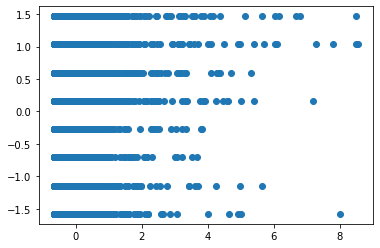

Logistic regression: 
coefficient of determination: 0.009110124946941967
slope: [[0.09544697]]
Correlation: 
           Tot_Benes      year
Tot_Benes   1.000000  0.095447
year        0.095447  1.000000
Analysis of GE65_Sprsn_Flag and GE65_Tot_Clms
Analysis of GE65_Sprsn_Flag and GE65_Tot_30day_Fills
Analysis of GE65_Sprsn_Flag and GE65_Tot_Drug_Cst
Analysis of GE65_Sprsn_Flag and GE65_Tot_Day_Suply
Analysis of GE65_Sprsn_Flag and GE65_Bene_Sprsn_Flag
Scatter plot: 


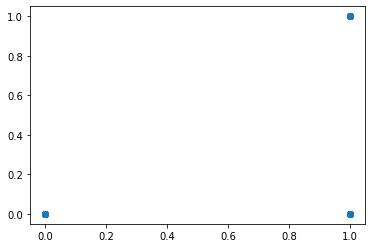

Logistic regression: 
coefficient of determination: 0.22599444869501883
slope: [[0.46873652]]
Correlation: 
                      GE65_Sprsn_Flag  GE65_Bene_Sprsn_Flag
GE65_Sprsn_Flag              1.000000              0.475389
GE65_Bene_Sprsn_Flag         0.475389              1.000000
Analysis of GE65_Sprsn_Flag and GE65_Tot_Benes
Analysis of GE65_Sprsn_Flag and year
Scatter plot: 


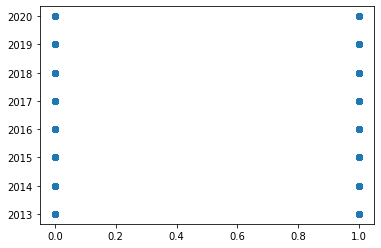

Logistic regression: 
coefficient of determination: 0.005766854547394229
slope: [[0.36863964]]
Correlation: 
                 GE65_Sprsn_Flag     year
GE65_Sprsn_Flag          1.00000  0.07594
year                     0.07594  1.00000
Analysis of GE65_Tot_Clms and GE65_Tot_30day_Fills
Scatter plot: 


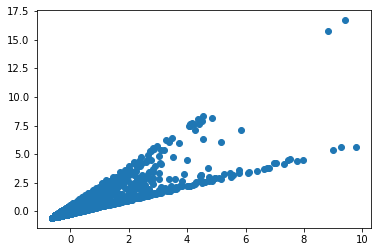

Logistic regression: 
coefficient of determination: 0.7760810166065756
slope: [[0.88095461]]
Correlation: 
                      GE65_Tot_Clms  GE65_Tot_30day_Fills
GE65_Tot_Clms              1.000000              0.880955
GE65_Tot_30day_Fills       0.880955              1.000000
Analysis of GE65_Tot_Clms and GE65_Tot_Drug_Cst
Scatter plot: 


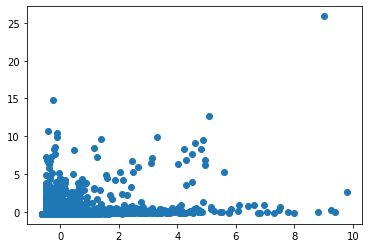

Logistic regression: 
coefficient of determination: 0.0652832190237077
slope: [[0.25550581]]
Correlation: 
                   GE65_Tot_Clms  GE65_Tot_Drug_Cst
GE65_Tot_Clms           1.000000           0.255506
GE65_Tot_Drug_Cst       0.255506           1.000000
Analysis of GE65_Tot_Clms and GE65_Tot_Day_Suply
Scatter plot: 


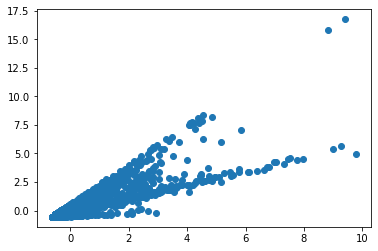

Logistic regression: 
coefficient of determination: 0.7543671698995782
slope: [[0.86854313]]
Correlation: 
                    GE65_Tot_Clms  GE65_Tot_Day_Suply
GE65_Tot_Clms            1.000000            0.868543
GE65_Tot_Day_Suply       0.868543            1.000000
Analysis of GE65_Tot_Clms and GE65_Bene_Sprsn_Flag
Scatter plot: 


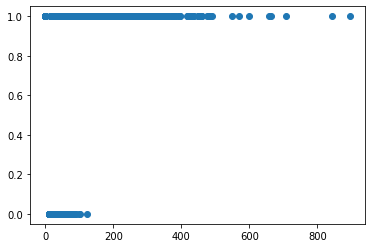

Logistic regression: 
coefficient of determination: 0.2543134643066538
slope: [[0.00319173]]
Correlation: 
                      GE65_Tot_Clms  GE65_Bene_Sprsn_Flag
GE65_Tot_Clms              1.000000              0.504295
GE65_Bene_Sprsn_Flag       0.504295              1.000000
Analysis of GE65_Tot_Clms and GE65_Tot_Benes
Scatter plot: 


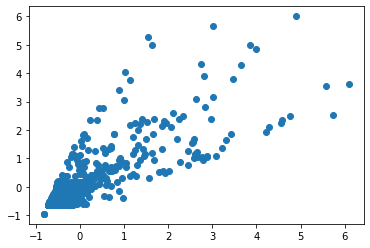

Logistic regression: 
coefficient of determination: 0.6654561550244513
slope: [[0.81575496]]
Correlation: 
                GE65_Tot_Clms  GE65_Tot_Benes
GE65_Tot_Clms        1.000000        0.815755
GE65_Tot_Benes       0.815755        1.000000
Analysis of GE65_Tot_Clms and year
Scatter plot: 


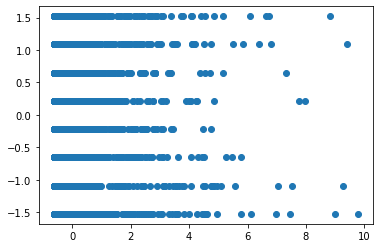

Logistic regression: 
coefficient of determination: 0.0001575934236730525
slope: [[-0.01255362]]
Correlation: 
               GE65_Tot_Clms      year
GE65_Tot_Clms       1.000000 -0.012554
year               -0.012554  1.000000
Analysis of GE65_Tot_30day_Fills and GE65_Tot_Drug_Cst
Scatter plot: 


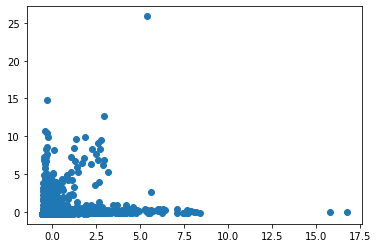

Logistic regression: 
coefficient of determination: 0.021182108446361925
slope: [[0.14554074]]
Correlation: 
                      GE65_Tot_30day_Fills  GE65_Tot_Drug_Cst
GE65_Tot_30day_Fills              1.000000           0.145541
GE65_Tot_Drug_Cst                 0.145541           1.000000
Analysis of GE65_Tot_30day_Fills and GE65_Tot_Day_Suply
Scatter plot: 


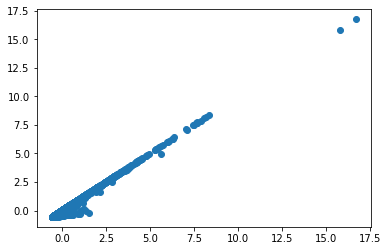

Logistic regression: 
coefficient of determination: 0.9931524157176022
slope: [[0.99657033]]
Correlation: 
                      GE65_Tot_30day_Fills  GE65_Tot_Day_Suply
GE65_Tot_30day_Fills               1.00000             0.99657
GE65_Tot_Day_Suply                 0.99657             1.00000
Analysis of GE65_Tot_30day_Fills and GE65_Bene_Sprsn_Flag
Scatter plot: 


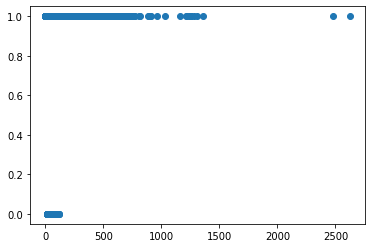

Logistic regression: 
coefficient of determination: 0.20168083817173665
slope: [[0.00149281]]
Correlation: 
                      GE65_Tot_30day_Fills  GE65_Bene_Sprsn_Flag
GE65_Tot_30day_Fills              1.000000              0.449089
GE65_Bene_Sprsn_Flag              0.449089              1.000000
Analysis of GE65_Tot_30day_Fills and GE65_Tot_Benes
Scatter plot: 


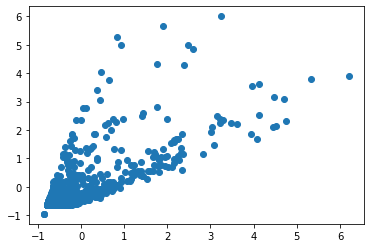

Logistic regression: 
coefficient of determination: 0.5300827756710056
slope: [[0.72806784]]
Correlation: 
                      GE65_Tot_30day_Fills  GE65_Tot_Benes
GE65_Tot_30day_Fills              1.000000        0.728068
GE65_Tot_Benes                    0.728068        1.000000
Analysis of GE65_Tot_30day_Fills and year
Scatter plot: 


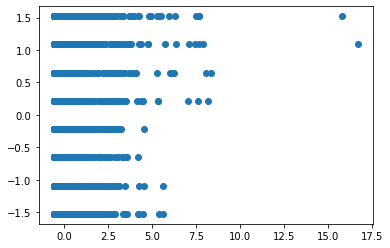

Logistic regression: 
coefficient of determination: 0.005875211555986692
slope: [[0.07664993]]
Correlation: 
                      GE65_Tot_30day_Fills     year
GE65_Tot_30day_Fills               1.00000  0.07665
year                               0.07665  1.00000
Analysis of GE65_Tot_Drug_Cst and GE65_Tot_Day_Suply
Scatter plot: 


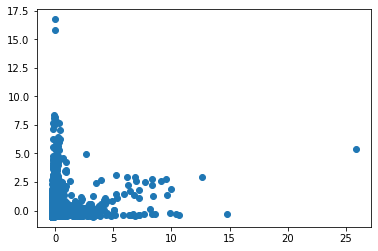

Logistic regression: 
coefficient of determination: 0.021707708774497902
slope: [[0.14733536]]
Correlation: 
                    GE65_Tot_Drug_Cst  GE65_Tot_Day_Suply
GE65_Tot_Drug_Cst            1.000000            0.147335
GE65_Tot_Day_Suply           0.147335            1.000000
Analysis of GE65_Tot_Drug_Cst and GE65_Bene_Sprsn_Flag
Scatter plot: 


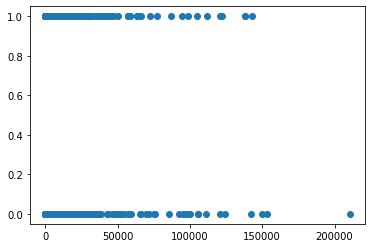

Logistic regression: 
coefficient of determination: 0.0011135004428507456
slope: [[1.26417989e-06]]
Correlation: 
                      GE65_Tot_Drug_Cst  GE65_Bene_Sprsn_Flag
GE65_Tot_Drug_Cst              1.000000              0.033369
GE65_Bene_Sprsn_Flag           0.033369              1.000000
Analysis of GE65_Tot_Drug_Cst and GE65_Tot_Benes
Scatter plot: 


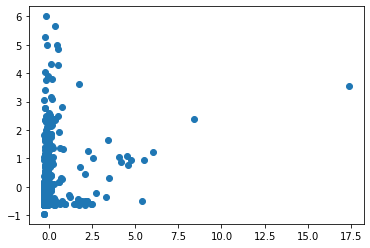

Logistic regression: 
coefficient of determination: 0.051274638403664086
slope: [[0.22643904]]
Correlation: 
                   GE65_Tot_Drug_Cst  GE65_Tot_Benes
GE65_Tot_Drug_Cst           1.000000        0.226439
GE65_Tot_Benes              0.226439        1.000000
Analysis of GE65_Tot_Drug_Cst and year
Scatter plot: 


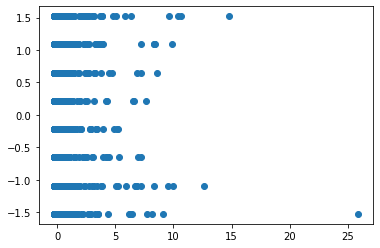

Logistic regression: 
coefficient of determination: 6.066017933070711e-06
slope: [[0.00246293]]
Correlation: 
                   GE65_Tot_Drug_Cst      year
GE65_Tot_Drug_Cst           1.000000  0.002463
year                        0.002463  1.000000
Analysis of GE65_Tot_Day_Suply and GE65_Bene_Sprsn_Flag
Scatter plot: 


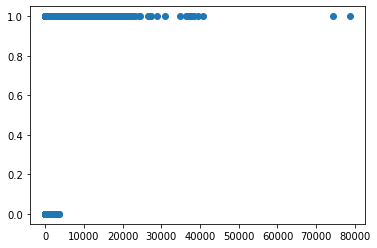

Logistic regression: 
coefficient of determination: 0.1975738981325651
slope: [[4.93027209e-05]]
Correlation: 
                      GE65_Tot_Day_Suply  GE65_Bene_Sprsn_Flag
GE65_Tot_Day_Suply              1.000000              0.444493
GE65_Bene_Sprsn_Flag            0.444493              1.000000
Analysis of GE65_Tot_Day_Suply and GE65_Tot_Benes
Scatter plot: 


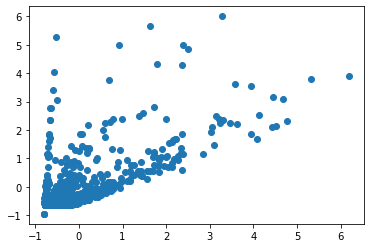

Logistic regression: 
coefficient of determination: 0.44658016635405595
slope: [[0.66826654]]
Correlation: 
                    GE65_Tot_Day_Suply  GE65_Tot_Benes
GE65_Tot_Day_Suply            1.000000        0.668267
GE65_Tot_Benes                0.668267        1.000000
Analysis of GE65_Tot_Day_Suply and year
Scatter plot: 


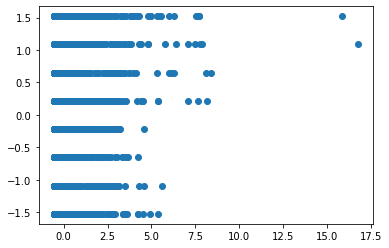

Logistic regression: 
coefficient of determination: 0.005067736772655929
slope: [[0.07118804]]
Correlation: 
                    GE65_Tot_Day_Suply      year
GE65_Tot_Day_Suply            1.000000  0.071188
year                          0.071188  1.000000
Analysis of GE65_Bene_Sprsn_Flag and GE65_Tot_Benes
Analysis of GE65_Bene_Sprsn_Flag and year
Scatter plot: 


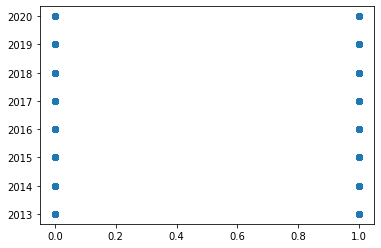

Logistic regression: 
coefficient of determination: 0.0011583850813640106
slope: [[0.1677921]]
Correlation: 
                      GE65_Bene_Sprsn_Flag      year
GE65_Bene_Sprsn_Flag              1.000000  0.034035
year                              0.034035  1.000000
Analysis of GE65_Tot_Benes and year
Scatter plot: 


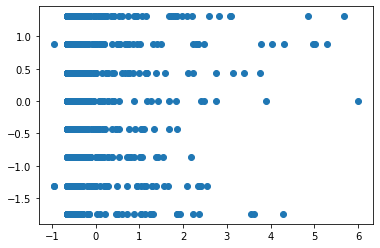

Logistic regression: 
coefficient of determination: 0.00016438688410180813
slope: [[0.01282134]]
Correlation: 
                GE65_Tot_Benes      year
GE65_Tot_Benes        1.000000  0.012821
year                  0.012821  1.000000


In [50]:
columns = ["Prscrbr_Type_Src",'Tot_Clms','Tot_30day_Fills','Tot_Day_Suply','Tot_Drug_Cst','Tot_Benes','GE65_Sprsn_Flag','GE65_Tot_Clms','GE65_Tot_30day_Fills','GE65_Tot_Drug_Cst','GE65_Tot_Day_Suply','GE65_Bene_Sprsn_Flag','GE65_Tot_Benes','year']
dummys = ["Prscrbr_Type_Src","GE65_Sprsn_Flag","GE65_Bene_Sprsn_Flag"]
for pos, column1 in enumerate(columns):
    for column2 in columns[pos + 1:]:
        print("Analysis of " + column1 + " and " + column2)
        df = ps_df.copy()
        df = df[[column1, column2]]
        # Drop all rows that contain a missing value
        df = df.dropna()
        if len(df.index) == 0:
            continue
        
        if not((column1 in dummys) or (column2 in dummys)):
            df[column1] = stats.zscore(df[column1])
            df[column2] = stats.zscore(df[column2])
        
        print("Scatter plot: ")
        plt.scatter(df[column1], df[column2])
        plt.show()
        print("Logistic regression: ")
        model = LinearRegression()
        x = df[[column1]]
        y = df[[column2]]
        model.fit(x, y)
        r_sq = model.score(x, y)
        print(f"coefficient of determination: {r_sq}")
        print(f"slope: {model.coef_}")
        corr_df = df[[column1,column2]]
        print("Correlation: ")
        print(corr_df.corr())
        

### Comparisons of note:

#### Analysis of Tot_Clms and GE65_Tot_Benes
#### Analysis of Tot_Clms and GE65_Bene_Sprsn_Flag
#### Analysis of Tot_30day_Fills and Tot_Benes
#### Analysis of Tot_30day_Fills and GE65_Tot_Benes
#### Analysis of Tot_Day_Suply and Tot_Benes
#### Analysis of Tot_Day_Suply and GE65_Tot_Benes
#### Analysis of Tot_Benes and GE65_Tot_30day_Fills
#### Analysis of Tot_Benes and GE65_Tot_Day_Suply
#### Analysis of GE65_Tot_30day_Fills and GE65_Tot_Benes
#### Analysis of GE65_Tot_Day_Suply and GE65_Tot_Benes

### To do:

#### DMEPOS bivariant analysis
#### Combine datasets and perform same analysis
#### Logicaly understand better what correlations are redundant and what correlations may be useful